# Figure 10: MHC class I divergence 

#### Evolutionary divergence 
#### Functional divergence: https://www.science.org/doi/10.1126/science.adk0777 
#### Functional divergence based on NetMHCpan-4.1
#### for cancer phenotype, I will use first.diagnosed.cancer.type1 column

# Set up

In [2]:
# imported packages
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as plticker
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.patches import Polygon
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import cm
import scipy.special
import scipy.integrate as it
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.stats import kde
import copy
import glob, os
import re
# from sklearn import datasets, linear_model
import pandas as pd
from decimal import *
from operator import itemgetter    
from collections import OrderedDict
import timeit
import time 
import csv
import seaborn as sns 
import scipy as sp
from sklearn.preprocessing import LabelEncoder
from matplotlib.ticker import LogLocator
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from myfunctions import transform_format


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
# get current date 
timestr = time.strftime("%Y%m%d") 

In [4]:
# specify font size for plotting 
plt.rcParams.update({'font.sans-serif':'Arial'})

# Load datasets

## MHC genotype (UKBB)

In [5]:

# path to file
file_hla = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/UKBB/ukb_typed_hla_with_ids_07_threshold_processed.txt"

# get the header 
header = pd.read_csv(file_hla, sep='\t', nrows=1, header=None).values.tolist()
head = [item for sublist in header for item in sublist]

# get the actual dataframe 
df_hla = pd.read_csv(file_hla, skiprows = 1, sep = ' ', header = None)

# add columns 
df_hla.columns = head 

# QUALITY CONTROL (check how genotyping went)
# count in how many cases we're not sure on the allele genotype
df_hla1 = df_hla.filter(regex='^(Person_|A_|B_|C_)') # 488377 cases 
df_hla2 = df_hla.filter(regex='^(Person_|D)') # 488377 cases 

df_hla1_count_05 = df_hla1.values.flatten().tolist().count(0.5)
df_hla1_count_15 = df_hla1.values.flatten().tolist().count(1.5)

df_hla2_count_05 = df_hla2.values.flatten().tolist().count(0.5)
df_hla2_count_15 = df_hla2.values.flatten().tolist().count(1.5)

print('Number of 0.5 typing for HLA class I:', df_hla1_count_05)
print('Number of 1.5 typing for HLA class I:', df_hla1_count_15)
print('Number of 0.5 typing for HLA class II:', df_hla2_count_05)
print('Number of 1.5 typing for HLA class II:', df_hla2_count_15)

# SELECT MHC CLASS I and CLASS II
df_hla1 = df_hla.filter(regex='^(Person_|A_|B_|C_)') # 488377 cases 
df_hla2 = df_hla.filter(regex='^(Person_|D)') # 488377 cases 

# FILTERING (separately for MHC class I and MHC class II)
# filtering wise: exclude individuals with 0.5 genotype
# if someone is genotyped as 1.5, change to 2 
# this is the filtering used in https://www.science.org/doi/10.1126/science.adi3808, I think it makes sense so I will stick with this 
df_clean_hla1 = df_hla1[~df_hla1.isin([0.5]).any(axis=1)] # exclude people for whom we lack a genotype
df_clean_hla1 = df_clean_hla1[~df_clean_hla1.isin([1.5]).any(axis=1)] # exclude people for whom we lack a genotype

df_clean_hla2 = df_hla2[~df_hla2.isin([0.5]).any(axis=1)] # exclude people for whom we lack a genotype
df_clean_hla2 = df_clean_hla2[~df_clean_hla2.isin([1.5]).any(axis=1)] # exclude people for whom we lack a genotype

print("Number of samples with genotype data:", df_hla.shape[0])

# SPLIT MHC class II into DRB / DP / DQ
df_hla2_dp = df_clean_hla2.filter(regex='^(Person_|DP)')
df_hla2_dq = df_clean_hla2.filter(regex='^(Person_|DQ)')
df_hla2_dr = df_clean_hla2.filter(regex='^(Person_|DR)')

# obtain lists of Pariticipant IDs with correctly typed MHC data
ids_mhc1 = df_clean_hla1.Person_ID.unique()
ids_mhc2 = df_clean_hla2.Person_ID.unique()
ids_mhc1_mhc2 = set(ids_mhc1).intersection(set(ids_mhc2)) # intersection 

print("Number of samples which were correctly genotyped for MHC class I:", len(ids_mhc1))
print("Number of samples which were correctly genotyped for MHC class II:", len(ids_mhc2))
print("Number of samples which were correctly genotyped for MHC class I and class II:", len(ids_mhc1_mhc2))

# NOTE
# Because there is a different number of people with correctly typed MHC class I vs class II alleles
# I will first analyse these separately and then will do analysis of MHC class I + class II on these who only have both class I and class II correct 
# I want to run stuff separately to not lose valuable data ofc 

Number of 0.5 typing for HLA class I: 45538
Number of 1.5 typing for HLA class I: 2565
Number of 0.5 typing for HLA class II: 106986
Number of 1.5 typing for HLA class II: 25163
Number of samples with genotype data: 488377
Number of samples which were correctly genotyped for MHC class I: 443620
Number of samples which were correctly genotyped for MHC class II: 378317
Number of samples which were correctly genotyped for MHC class I and class II: 346968


## Evolutionary divergence (HED) for MHC class I A, B, C

In [6]:

# evolutionary divergence file for everyone genotyped correctly in the UKBB 
hed_0 = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/20240229_df_for_HED_prediction_HLA1_0_out.txt', sep = '\t')
hed_1 = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/20240229_df_for_HED_prediction_HLA1_1_out.txt', sep = '\t')
hed_2 = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/20240229_df_for_HED_prediction_HLA1_2_out.txt', sep = '\t')
hed_3 = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/20240229_df_for_HED_prediction_HLA1_3_out.txt', sep = '\t')
hed_4 = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/20240229_df_for_HED_prediction_HLA1_4_out.txt', sep = '\t')
hed_5 = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/20240229_df_for_HED_prediction_HLA1_5_out.txt', sep = '\t')
hed_6 = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/20240229_df_for_HED_prediction_HLA1_6_out.txt', sep = '\t')
hed_7 = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/20240229_df_for_HED_prediction_HLA1_7_out.txt', sep = '\t')
hed_8 = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/20240229_df_for_HED_prediction_HLA1_8_out.txt', sep = '\t')

# first concat files to only do it once
hed_df = pd.concat([hed_0, hed_1, hed_2, hed_3, hed_4, hed_5, hed_6, hed_7, hed_8], axis = 0)
hed_df.head()


,Sample,Alleles,HED_A,HED_B,HED_C,Mean_HED
0,Pt01,"A0201,B4001,B4402,C0304,C0501",NaN,9.640884,4.237569,NaN
1,Pt02,"A0101,B0801,B5701,C0602,C0701",NaN,14.099448,3.116022,NaN
2,Pt03,"A2301,A2402,B1801,B5701,C0501,C0602",1.077348,11.729282,5.524862,6.110497
3,Pt04,"A0101,B0702,B5701,C0602,C0702",NaN,14.243094,3.392265,NaN
4,Pt05,"A0201,A1101,B5501,B5701,C0303,C0602",8.104972,11.082873,7.276243,8.821363


In [7]:

# identify the Patient IDs corresponding to indices used for predictions 
hed_df['sample_index'] = hed_df['Sample'].str.extract('(\d+)') # we need to 1) remove 'Pt', get out the numbers, drop 0 (convert to integer), and substract 1
hed_df['sample_index'] = hed_df['Sample'].str.extract('(\d+)')
hed_df['sample_index'] = hed_df['sample_index'].astype(int) - 1

# match sample index to Person_ID in the UKBB data

# create a column in the df_hla1 clean data with index of the same 
df_clean_hla1['sample_index'] = df_clean_hla1.index
df_hla1_indices_ids = df_clean_hla1[['sample_index', 'Person_ID']]

# match indices to patient IDs 
hed_df_with_ids = pd.merge(hed_df, df_hla1_indices_ids, on = 'sample_index')
hed_df_with_ids.head() # okay excellent! 

,Sample,Alleles,HED_A,HED_B,HED_C,Mean_HED,sample_index,Person_ID
0,Pt01,"A0201,B4001,B4402,C0304,C0501",NaN,9.640884,4.237569,NaN,0,2812213
1,Pt02,"A0101,B0801,B5701,C0602,C0701",NaN,14.099448,3.116022,NaN,1,4860169
2,Pt03,"A2301,A2402,B1801,B5701,C0501,C0602",1.077348,11.729282,5.524862,6.110497,2,3381323
3,Pt04,"A0101,B0702,B5701,C0602,C0702",NaN,14.243094,3.392265,NaN,3,2805252
4,Pt05,"A0201,A1101,B5501,B5701,C0303,C0602",8.104972,11.082873,7.276243,8.821363,4,1118855


In [8]:

# we can maybe get out HED from this + drop rows with na (these are if there was one allele only)
hed_alleles_a = hed_df[['Alleles', 'HED_A']].dropna()
hed_alleles_b = hed_df[['Alleles', 'HED_B']].dropna()
hed_alleles_c = hed_df[['Alleles', 'HED_C']].dropna()

# select allles that correspond to the class we have HED score for 
hed_alleles_a['allele_list'] = hed_alleles_a['Alleles'].str.split(',')
hed_alleles_b['allele_list'] = hed_alleles_b['Alleles'].str.split(',')
hed_alleles_c['allele_list'] = hed_alleles_c['Alleles'].str.split(',')

# define a function to filter out the list to only retain relevant values 
def filter_values(lst, letter):
    return [value for value in lst if value.startswith(letter)]

# Applying the function to each row in the DataFrame
hed_alleles_a['allele_list'] = hed_alleles_a['allele_list'].apply(filter_values, letter = 'A')
hed_alleles_b['allele_list'] = hed_alleles_b['allele_list'].apply(filter_values, letter = 'B')
hed_alleles_c['allele_list'] = hed_alleles_c['allele_list'].apply(filter_values, letter = 'C')

# specify allele 1 and allele 2
hed_alleles_a['allele_1'] = hed_alleles_a['allele_list'].str.get(0)
hed_alleles_a['allele_2'] = hed_alleles_a['allele_list'].str.get(1)

hed_alleles_b['allele_1'] = hed_alleles_b['allele_list'].str.get(0)
hed_alleles_b['allele_2'] = hed_alleles_b['allele_list'].str.get(1)

hed_alleles_c['allele_1'] = hed_alleles_c['allele_list'].str.get(0)
hed_alleles_c['allele_2'] = hed_alleles_c['allele_list'].str.get(1)

# identiy allele combination
hed_alleles_a['allele_comb'] = hed_alleles_a['allele_1'] + '-' + hed_alleles_a['allele_2']
hed_alleles_b['allele_comb'] = hed_alleles_b['allele_1'] + '-' + hed_alleles_b['allele_2']
hed_alleles_c['allele_comb'] = hed_alleles_c['allele_1'] + '-' + hed_alleles_c['allele_2']

# drop duplicates 
hed_alleles_a = hed_alleles_a.drop_duplicates(subset = ['HED_A', 'allele_comb'], keep=False)
hed_alleles_b = hed_alleles_b.drop_duplicates(subset = ['HED_B', 'allele_comb'], keep=False)
hed_alleles_c = hed_alleles_c.drop_duplicates(subset = ['HED_C', 'allele_comb'], keep=False)

# select only allele_1, allele_2 and HED
hed_alleles_a_sub = hed_alleles_a[['allele_1', 'allele_2', 'HED_A']]
hed_alleles_b_sub = hed_alleles_b[['allele_1', 'allele_2', 'HED_B']]
hed_alleles_c_sub = hed_alleles_c[['allele_1', 'allele_2', 'HED_C']]

# sort columns alphabetically 
hed_alleles_a_sub = hed_alleles_a_sub.sort_values(by=['allele_1', 'allele_2'])
hed_alleles_b_sub = hed_alleles_b_sub.sort_values(by=['allele_1', 'allele_2'])
hed_alleles_c_sub = hed_alleles_c_sub.sort_values(by=['allele_1', 'allele_2'])

# now pivot and see what you get 
hed_alleles_a_pivot = hed_alleles_a_sub.pivot(index='allele_2', columns='allele_1', values='HED_A')
hed_alleles_b_pivot = hed_alleles_b_sub.pivot(index='allele_2', columns='allele_1', values='HED_B')
hed_alleles_c_pivot = hed_alleles_c_sub.pivot(index='allele_2', columns='allele_1', values='HED_C')

# okay we got to this but have a lot of missing values (maybe there are not that many combinations in the end)
# if we dont desperately need this for anything, I'd say let it stay like this for now


## Functional divergence for MHC class I A, B, C alleles - Viard et al., 2024, Science

In [9]:

# again, need to get functions to fix formats
import re

# transform format (from NetMHCpan data to UKBB format)
def transform_format_netmhc(input_string):
    # a regular expression pattern to match the input format
    pattern = re.compile(r'HLA-(\w\S*)(\d{2}):(\d{2})')

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1).replace('*', '') # remove the star 
        group2 = int(match.group(2)) # remove zeros at the start 
        group3 = match.group(3) # leave as it is 

        # Format the output string
        output_string = f'{group1}_{group2}{group3}' # stitch back 
        return output_string # return transformed string 

    # if no much, return original string 
    return input_string

# transform format (from NetMHCpan data to UKBB format) - VERY annoyingly running the same pipeline I can get different formats of HLA allele names
def transform_format_netmhc_2(input_string):
    # a regular expression pattern to match the input format
    pattern = re.compile(r'HLA-(\w)(\d{2}):(\d{2})')

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1) # remove the star 
        group2 = int(match.group(2)) # remove zeros at the start 
        group3 = match.group(3) # leave as it is 

        # Format the output string
        output_string = f'{group1}_{group2}{group3}' # stitch back 
        return output_string # return transformed string 

    # if no much, return original string 
    return input_string

# transform format (from NetMHCpan data to UKBB format) - VERY annoyingly running the same pipeline I can get different formats of HLA allele names
def transform_format_from_fd(input_string):
    # a regular expression pattern to match the input format
    pattern = re.compile(r'(\w)(\d{2})(\d{2})')

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1) # remove the star 
        group2 = int(match.group(2)) # remove zeros at the start 
        group3 = match.group(3) # leave as it is 

        # Format the output string
        output_string = f'{group1}_{group2}{group3}' # stitch back 
        return output_string # return transformed string 

    # if no much, return original string 
    return input_string

# also transform format to what they are using in the FD dataset bc it looks better
def transform_format_to_fd(input_string):
    # a regular expression pattern to match the input format
    pattern = re.compile(r'(\w)_(\d+)(\d{2})')

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1) # remove the star 
        group2 = str(match.group(2)).zfill(2) # get the zeros at the beginning 
        group3 = match.group(3) # leave as it is 

        # Format the output string
        output_string = f'{group1}{group2}{group3}' # stitch back 
        return output_string # return transformed string 

    # if no much, return original string 
    return input_string


In [10]:

# I downloaded the dataset from https://www.science.org/doi/10.1126/science.adk0777 (data in fig S1)
# there are three sheets in the spreadhseet (class A, B, C) so I saved each file separately as a csv
# files are in msc_thesis/task1_predict_binding_to_HLA/data

fd_a = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/science.adk0777_data_s1_A.csv')
fd_b = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/science.adk0777_data_s1_B.csv')
fd_c = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/science.adk0777_data_s1_C.csv')


In [11]:

# for each, identify the two alleles you are going to deal with 
fd_a['allele_1'] = fd_a['geno'].str.split('_').str[0]
fd_a['allele_2'] = fd_a['geno'].str.split('_').str[1]

fd_b['allele_1'] = fd_b['geno'].str.split('_').str[0]
fd_b['allele_2'] = fd_b['geno'].str.split('_').str[1]

fd_c['allele_1'] = fd_c['geno'].str.split('_').str[0]
fd_c['allele_2'] = fd_c['geno'].str.split('_').str[1]


## Functional divergence for MHC class I A, B, C from NetMHCpan scores 

In [12]:

# Let's compare this to correlations you got with NetMHC pan 

pred_file_net = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/netMHC_out/scores/20240210_NetMHC_HLA_UKBB_with_affinities_bestscores.csv' # EL scores, BA scores, EL rank, BA rank, affinity prediction
pred_file_net2 = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/netMHC_out/scores/20240221_percent_ranks_for_each_variant_by_HLA.csv' # EL rank, sum of weakly binding peptides, sum of strongly binding peptides

pred_filename_net = pred_file_net.split('/')[2].split('.')[0]
pred_filename_net2 = pred_file_net2.split('/')[2].split('.')[0]
pred_method_net = pred_file_net.split('_out')[0]

# Organize NetMHC scores 
netmhc = pd.read_csv(pred_file_net)
netmhc2 = pd.read_csv(pred_file_net2)

# in the original file, I am using "STOP" to indicate stop codons
# I need to change it to "*" to ensure consistent names for variants 
netmhc2['variant'] = netmhc2['variant'].str.replace('STOP', '*')

# rename collumns in NetMHC
netmhc = netmhc.rename(columns={'Aff(nM)': 'Aff_nM'}) # rename affinity column 
netmhc2 = netmhc2.rename(columns={'allele': 'HLA'}) # rename affinity column 
netmhc2 = netmhc2.rename(columns={'min_rank': '%Rank_EL_2'}) # rename affinity column 

# uniform HLA allele naming format
NET_col = netmhc.HLA
NET_formatted = NET_col.apply(transform_format_netmhc)
netmhc = pd.concat([netmhc, NET_formatted.rename('HLA_formatted')], axis = 1)
NET_col2 = netmhc2.HLA
NET_formatted2 = NET_col2.apply(transform_format_netmhc_2)
netmhc2 = pd.concat([netmhc2, NET_formatted2.rename('HLA_formatted')], axis = 1)

# select required columns
netmhc = netmhc[['HLA_formatted', 'Peptide', '%Rank_EL', 'Score_EL', '%Rank_BA', 'Score_BA', 'Aff_nM', 'gene', 'variant', 'genotype']]
netmhc2 = netmhc2[['HLA_formatted', '%Rank_EL_2', 'sum_peptides_below_05', 'sum_peptides_below_2', 'gene', 'variant', 'genotype']]

# sort both dataframes so that is easier to compare values
netmhc = netmhc.sort_values(by=['HLA_formatted', 'gene', 'variant', 'genotype'])
netmhc2 = netmhc2.sort_values(by=['HLA_formatted', 'gene', 'variant', 'genotype'])

# merge two dataframes for netmhc
netmhc_all = pd.merge(netmhc, netmhc2, on = ['HLA_formatted', 'gene', 'variant', 'genotype'])

netmhc_all['gene_var_gt'] = netmhc_all['gene'] + '_' + netmhc_all['variant'] + '_' + netmhc_all['genotype'] # add complete genotype data
netmhc_all['gene_var'] = netmhc_all['gene'] + '_' + netmhc_all['variant']
netmhc_all = netmhc_all.rename(columns={'Aff(nM)': 'Aff_nM'}) # rename affinity column 
scores_netmhc = netmhc_all[['HLA_formatted', 'Score_EL', '%Rank_EL', 'Score_BA', '%Rank_BA', 'Aff_nM', 'gene_var', 'gene_var_gt']] # select columns of interest

scores_netmhc['HLA_formatted_FD'] = scores_netmhc['HLA_formatted'].apply(transform_format_to_fd)

/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_59305/4154886919.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_netmhc['HLA_formatted_FD'] = scores_netmhc['HLA_formatted'].apply(transform_format_to_fd)


In [13]:
netmhc_a = scores_netmhc[scores_netmhc['HLA_formatted'].str.startswith('A')]
netmhc_b = scores_netmhc[scores_netmhc['HLA_formatted'].str.startswith('B')]
netmhc_c = scores_netmhc[scores_netmhc['HLA_formatted'].str.startswith('C')]

netmhc_a_wide = pd.pivot(netmhc_a, index='gene_var_gt', columns='HLA_formatted_FD', values='%Rank_EL')
netmhc_a_wide = netmhc_a_wide.reset_index()

netmhc_b_wide = pd.pivot(netmhc_b, index='gene_var_gt', columns='HLA_formatted_FD', values='%Rank_EL')
netmhc_b_wide = netmhc_b_wide.reset_index()

netmhc_c_wide = pd.pivot(netmhc_c, index='gene_var_gt', columns='HLA_formatted_FD', values='%Rank_EL')
netmhc_c_wide = netmhc_c_wide.reset_index()


In [14]:
# only subset alleles for which we have functional divergence
alleles_a = fd_a.allele_1.tolist()
alleles_b = fd_b.allele_1.tolist()
alleles_c = fd_c.allele_1.tolist()

netmhc_a_sub = scores_netmhc[scores_netmhc['HLA_formatted_FD'].isin(alleles_a)]
netmhc_b_sub = scores_netmhc[scores_netmhc['HLA_formatted_FD'].isin(alleles_b)]
netmhc_c_sub = scores_netmhc[scores_netmhc['HLA_formatted_FD'].isin(alleles_c)]

netmhc_a_wide_sub = pd.pivot(netmhc_a_sub, index='gene_var_gt', columns='HLA_formatted_FD', values='%Rank_EL')
netmhc_a_wide_sub = netmhc_a_wide_sub.reset_index()

netmhc_b_wide_sub = pd.pivot(netmhc_b_sub, index='gene_var_gt', columns='HLA_formatted_FD', values='%Rank_EL')
netmhc_b_wide_sub = netmhc_b_wide_sub.reset_index()

netmhc_c_wide_sub = pd.pivot(netmhc_c_sub, index='gene_var_gt', columns='HLA_formatted_FD', values='%Rank_EL')
netmhc_c_wide_sub = netmhc_c_wide_sub.reset_index()

In [15]:

# Option 2 for distance metric: Hamming distance (across all variants)

# define a function to create new values based on the threshold 
def map_values_threshold(x):

    if isinstance(x, (int, float)):
        if x < 0.5: # this indicates strong binding 
            return 1 # binds 
        
        elif x < 2: # this indicates weak binding 
            return 0.5 # weakly binds 
        
        else: # this indicates no binding 
            return 0 # does not bind 
    else:
        return x # we don't want to change non-numerical columns so just return the input 


In [16]:

# create dataframes for each allele class 
netmhc_a_threshold = netmhc_a[['HLA_formatted', '%Rank_EL', 'gene_var_gt']]  
netmhc_a_threshold = netmhc_a_threshold.applymap(map_values_threshold) # create a new df with mapped values 
netmhc_a_threshold['HLA_formatted2'] = netmhc_a_threshold['HLA_formatted'].apply(transform_format_to_fd) # change allele names to nice format

netmhc_b_threshold = netmhc_b[['HLA_formatted', '%Rank_EL', 'gene_var_gt']]  
netmhc_b_threshold = netmhc_b_threshold.applymap(map_values_threshold) # create a new df with mapped values 
netmhc_b_threshold['HLA_formatted2'] = netmhc_b_threshold['HLA_formatted'].apply(transform_format_to_fd) # change allele names to nice format

netmhc_c_threshold = netmhc_c[['HLA_formatted', '%Rank_EL', 'gene_var_gt']]  
netmhc_c_threshold = netmhc_c_threshold.applymap(map_values_threshold) # create a new df with mapped values 
netmhc_c_threshold['HLA_formatted2'] = netmhc_c_threshold['HLA_formatted'].apply(transform_format_to_fd) # change allele names to nice format


In [17]:

# okay now we want to do this for all variants we have looked at

# define a function to compare across all scores 
def compare_scores(df, a1, a2):
    
    same_score_count = 0
    diff_score_count = 0

    # compare scores for each variant 

    for variant in df.index: 

        # find scores 
        score_a1 = df.at[variant, a1]
        score_a2 = df.at[variant, a2]

        # compare scores 
        if score_a1 == score_a2: # if scores are the same, add to count of identical scores 
            same_score_count += 1
        elif abs(score_a1 - score_a2) <= 0.5: # if there is some difference > different but not as much 
            diff_score_count += 0.5
        else: # if very different (strong binding vs no binidng) > different 
            diff_score_count += 1
    
    return same_score_count - diff_score_count # Hamming-distance like measure 

# Calculate similarity scores for all pairs of objects
def get_all_scores(df):
    
    similarity_scores = {}
    
    for i, a1 in enumerate(df.columns): # take allele 1
        for j, a2 in enumerate(df.columns): # take allele 2
            similarity_scores[(a1,a2)] = compare_scores(df, a1, a2)
    
    similarity_scores_df = pd.DataFrame(similarity_scores.items(), columns = ['allele_combination', 'NetMHC_score'])

    return similarity_scores_df

In [18]:

# pivot the dataframe so you have HLA alleles in columns
netmhc_a_threshold_pivot = pd.pivot(netmhc_a_threshold, index='gene_var_gt', columns='HLA_formatted2', values='%Rank_EL')
netmhc_b_threshold_pivot = pd.pivot(netmhc_b_threshold, index='gene_var_gt', columns='HLA_formatted2', values='%Rank_EL')
netmhc_c_threshold_pivot = pd.pivot(netmhc_c_threshold, index='gene_var_gt', columns='HLA_formatted2', values='%Rank_EL')

# apply the function to obtain similarity scores 
netmhc_a_scores_df = get_all_scores(netmhc_a_threshold_pivot)
netmhc_a_scores_df[['allele_1', 'allele_2']] = netmhc_a_scores_df['allele_combination'].astype(str).str.strip('()').str.split(', ', expand=True).astype('category')
netmhc_a_scores_df['allele_1'] = netmhc_a_scores_df['allele_1'].str.strip("'")
netmhc_a_scores_df['allele_2'] = netmhc_a_scores_df['allele_2'].str.strip("'")

netmhc_b_scores_df = get_all_scores(netmhc_b_threshold_pivot)
netmhc_b_scores_df[['allele_1', 'allele_2']] = netmhc_b_scores_df['allele_combination'].astype(str).str.strip('()').str.split(', ', expand=True).astype('category')
netmhc_b_scores_df['allele_1'] = netmhc_b_scores_df['allele_1'].str.strip("'")
netmhc_b_scores_df['allele_2'] = netmhc_b_scores_df['allele_2'].str.strip("'")

netmhc_c_scores_df = get_all_scores(netmhc_c_threshold_pivot)
netmhc_c_scores_df[['allele_1', 'allele_2']] = netmhc_c_scores_df['allele_combination'].astype(str).str.strip('()').str.split(', ', expand=True).astype('category')
netmhc_c_scores_df['allele_1'] = netmhc_c_scores_df['allele_1'].str.strip("'")
netmhc_c_scores_df['allele_2'] = netmhc_c_scores_df['allele_2'].str.strip("'")

# create heatmaps to display similarity scores 
netmhc_a_scores_df_pivot = netmhc_a_scores_df.pivot(index='allele_2', columns='allele_1', values='NetMHC_score') 
netmhc_b_scores_df_pivot = netmhc_b_scores_df.pivot(index='allele_2', columns='allele_1', values='NetMHC_score') 
netmhc_c_scores_df_pivot = netmhc_c_scores_df.pivot(index='allele_2', columns='allele_1', values='NetMHC_score') 

In [19]:
# you can subset the df and do just for the subset 
netmhc_a_scores_df_sub = netmhc_a_scores_df[(netmhc_a_scores_df['allele_1'].isin(alleles_a) & netmhc_a_scores_df['allele_2'].isin(alleles_a))]
netmhc_b_scores_df_sub = netmhc_b_scores_df[(netmhc_b_scores_df['allele_1'].isin(alleles_b) & netmhc_b_scores_df['allele_2'].isin(alleles_b))]
netmhc_c_scores_df_sub = netmhc_c_scores_df[(netmhc_c_scores_df['allele_1'].isin(alleles_c) & netmhc_c_scores_df['allele_2'].isin(alleles_c))]

# change format of df (pivot)
netmhc_a_scores_df_pivot_sub = netmhc_a_scores_df_sub.pivot(index='allele_2', columns='allele_1', values='NetMHC_score') 
netmhc_b_scores_df_pivot_sub = netmhc_b_scores_df_sub.pivot(index='allele_2', columns='allele_1', values='NetMHC_score') 
netmhc_c_scores_df_pivot_sub = netmhc_c_scores_df_sub.pivot(index='allele_2', columns='allele_1', values='NetMHC_score') 

# Heterozygosity status

In [20]:

# add columns to indicate heterozygosity status 

# HLA_classI_A, HLA_classI_B, HLA_classI_C, HLA_classII_DRB, HLA_classII_DPA, HLA_classII_DPB, HLA_classII_DQA, HLA_classII_DQB, total_het_I, total_het_II, total_het 

# define a function to get names of columns which indicate alleles present in the sample 
def get_columns_with_values(row, subset_columns):
    return [col for col in subset_columns if row[col] > 0]
    

In [21]:

# apply function to class I alleles

# reminder: filtered data to use: df_clean_hla1, df_clean_hla2

# filter columns with MHC class I alleles (start with A_, B_, C_)
subset_A = [col for col in df_clean_hla1.columns if col.startswith(('A_'))]
subset_B = [col for col in df_clean_hla1.columns if col.startswith(('B_'))]
subset_C = [col for col in df_clean_hla1.columns if col.startswith(('C_'))]

subsets_1 = [subset_A, subset_B, subset_C]

for subset in subsets_1:
    
    new_column_name = 'allele_I_' + subset[0][0] # the first letter will indicate class
    df_clean_hla1[new_column_name] = df_clean_hla1.apply(get_columns_with_values, axis=1, subset_columns=subset).apply(lambda x: ', '.join(x))

df_clean_hla1.head(n = 5)

,Person_ID,A_101,A_102,A_103,A_201,A_202,A_203,A_205,A_206,A_207,...,C_1505,C_1601,C_1602,C_1604,C_1701,C_1801,sample_index,allele_I_A,allele_I_B,allele_I_C
0,2812213,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,A_201,"B_4001, B_4402","C_304, C_501"
1,4860169,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,A_101,"B_801, B_5701","C_602, C_701"
2,3381323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2,"A_2301, A_2402","B_1801, B_5701","C_501, C_602"
3,2805252,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3,A_101,"B_702, B_5701","C_602, C_702"
4,1118855,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4,"A_201, A_1101","B_5501, B_5701","C_303, C_602"


In [22]:

# apply function to class II alleles

subset_DR = [col for col in df_clean_hla2.columns if 'DRB1' in col] # this is the only one we want to look at at the moment 
subset_DPA = [col for col in df_clean_hla2.columns if 'DPA' in col]
subset_DPB = [col for col in df_clean_hla2.columns if 'DPB' in col]
subset_DQA = [col for col in df_clean_hla2.columns if 'DQA' in col]
subset_DQB = [col for col in df_clean_hla2.columns if 'DQB' in col]

subsets_2 = [subset_DR, subset_DPA, subset_DPB, subset_DQA, subset_DQB]

for subset in subsets_2:
    
    new_column_name = 'allele_II_' + subset[0][:3] # the first three letters indicate class
    df_clean_hla2[new_column_name] = df_clean_hla2.apply(get_columns_with_values, axis=1, subset_columns=subset).apply(lambda x: ', '.join(x))

df_clean_hla2.head(n = 5)

,Person_ID,DRB5_101,DRB5_102,DRB5_202,DRB5_9901,DRB4_101,DRB4_103,DRB4_9901,DRB3_101,DRB3_202,...,DPA1_107,DPA1_201,DPA1_202,DPA1_301,DPA1_401,allele_II_DRB,allele_II_DPA,allele_II_DPB,allele_II_DQA,allele_II_DQB
1,4860169,1.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,"DRB1_301, DRB1_1501",DPA1_103,"DPB1_301, DPB1_401","DQA1_102, DQA1_501","DQB1_201, DQB1_602"
2,3381323,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,"DRB1_101, DRB1_401",DPA1_103,"DPB1_201, DPB1_401","DQA1_101, DQA1_301","DQB1_302, DQB1_501"
3,2805252,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,"DRB1_401, DRB1_1501","DPA1_103, DPA1_202","DPB1_101, DPB1_401","DQA1_102, DQA1_301","DQB1_301, DQB1_602"
5,3318036,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,DRB1_701,DPA1_201,DPB1_1101,DQA1_201,DQB1_202
6,4120291,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,"DRB1_103, DRB1_701",DPA1_201,"DPB1_1001, DPB1_1101","DQA1_101, DQA1_201","DQB1_202, DQB1_501"


In [23]:

# define a function to check if someone is heterozygous for a given class of alleles 
def is_heterozygous_allele(row, col):

    # count the number of alleles someone has 
    # count the number of commas + add 1 = number of entires
    count = row[col].count(',') + 1  
    
    # determine if they are heterozygous or homozygous 
    if count == 2:
        return True # has two alleles so heterozygous
    elif count == 1:
        return False # has 1 alleles so homozygous
    else:
        return None # we definitely should not have anything else !!! so return None and see in how many cases this happens

In [24]:
# list of columns we want to look at to determine heterozygosity status
columns_hla1 = ['allele_I_A', 'allele_I_B', 'allele_I_C']
columns_hla2 = ['allele_II_DRB', 'allele_II_DPA', 'allele_II_DPB', 'allele_II_DQA', 'allele_II_DQB']

for col in columns_hla1:
    new_column_name = 'het_' + col # the first three letters indicate class
    df_clean_hla1[new_column_name] = df_clean_hla1.apply(is_heterozygous_allele, axis=1, col = col) # add relevant column to the dataframe

for col in columns_hla2:
    new_column_name = 'het_' + col # the first three letters indicate class
    df_clean_hla2[new_column_name] = df_clean_hla2.apply(is_heterozygous_allele, axis=1, col = col) # add relevant column to the dataframe

In [25]:

# add total heterozygosity 
subset_classI = [col for col in df_clean_hla1.columns if col.startswith(('A_', 'B_', 'C_'))] # all class I alleles 
subset_classII = [col for col in df_clean_hla2.columns if col.startswith(('D'))] # all class II alleles 

# determine the number of unique alleles typed (so if someone has HLA_A0101, HLA_A0101, HLA_B0101, HLA_B0101, HLA_C0101, HLA_C0101, the count is 3)
df_clean_hla1['count_class_I'] = df_clean_hla1[subset_classI].gt(0).sum(axis=1)
df_clean_hla2['count_class_II'] = df_clean_hla2[subset_classII].gt(0).sum(axis=1)

# this is so we get only counts for the 10 alleles we are looking at
subset_classII_drb = [col for col in df_clean_hla2.columns if col.startswith('DRB1') or col.startswith('DP') or col.startswith(('DQ'))] # all class II alleles 
df_clean_hla2['count_class_II_drb'] = df_clean_hla2[subset_classII_drb].gt(0).sum(axis=1)

# determine the number of alleles typed (so if someone has HLA_A0101, HLA_A0101, HLA_B0101, HLA_B0101, HLA_C0101, HLA_C0101, the sum is 6)
df_clean_hla1['sum_class_I'] = df_clean_hla1[subset_classI].sum(axis=1)
df_clean_hla2['sum_class_II'] = df_clean_hla2[subset_classII].sum(axis=1)

# note that some people may not have been fully genotyped > I guess we should think about what to do with these cases 
df_clean_hla1['het_all_class_I'] = (df_clean_hla1['count_class_I'] == 6) # we dropped people who did not have genotype data available so if they dont have 6 alleles they are homozygous by our definition
df_clean_hla2['het_all_class_II'] = (df_clean_hla2['count_class_II'] == 10) 

# one way to check for total heterozygosity is to see whether you have 'TRUE' in all fields (het_allele A, B, C / het allele DRB, DPA, DPB, DQA, DQB)
df_clean_hla1['het_all_class_I_from_allele'] = (df_clean_hla1['het_allele_I_A'] & df_clean_hla1['het_allele_I_B'] & df_clean_hla1['het_allele_I_C'])
df_clean_hla2['het_all_class_II_from_allele'] = (df_clean_hla2['het_allele_II_DRB'] & df_clean_hla2['het_allele_II_DPB'] &df_clean_hla2['het_allele_II_DPA'] & df_clean_hla2['het_allele_II_DQB'] & df_clean_hla2['het_allele_II_DQA'])


#### Check: plot proportion of heterozygotes in the UKBB

In [26]:

# subset the data to only include ID and sums of alleles 
selected_columns1 = [col for col in df_clean_hla1.columns if not col.startswith(('A_', 'B_', 'C_'))]
subset_df1 = df_clean_hla1[selected_columns1]

selected_columns2 = [col for col in df_clean_hla2.columns if not col.startswith(('D_'))]
subset_df2 = df_clean_hla2[selected_columns2]

cols1 = ['het_all_class_I_from_allele', 'het_allele_I_A', 'het_allele_I_B', 'het_allele_I_C'] 
cols2 = ['het_all_class_II_from_allele', 'het_allele_II_DRB', 'het_allele_II_DQB', 'het_allele_II_DQA', 'het_allele_II_DPB', 'het_allele_II_DPA']

labels1 = ['class I', 'class I A', 'class I B', 'class I C']
labels2 = ['class II', 'class II DRB1', 'class II DQB', 'class II DQA', 'class II DPB', 'class II DPA']

sum_het1 = [df_clean_hla1[col].sum() for col in cols1]
total1 = len(df_clean_hla1['Person_ID'].unique())
percent_het1 = [s / total1 * 100 for s in sum_het1]
percent_hom1 = [100 - p for p in percent_het1]

sum_het2 = [df_clean_hla2[col].sum() for col in cols2]
total2 = len(df_clean_hla2['Person_ID'].unique())
percent_het2 = [s / total2 * 100 for s in sum_het2]
percent_hom2 = [100 - p for p in percent_het2]

df_percents1 = pd.DataFrame([percent_het1, percent_hom1, labels1]).T
df_percents1.columns = ['percent_heterozygous', 'percent_homozygous', 'label']

df_percents2 = pd.DataFrame([percent_het2, percent_hom2, labels2]).T
df_percents2.columns = ['percent_heterozygous', 'percent_homozygous', 'label']

df_percents = pd.concat([df_percents1, df_percents2], axis = 0)
df_percents

,percent_heterozygous,percent_homozygous,label
0,77.052432,22.947568,class I
1,85.100987,14.899013,class I A
2,92.034173,7.965827,class I B
3,89.538118,10.461882,class I C
0,26.193378,73.806622,class II
1,89.753831,10.246169,class II DRB1
2,88.158608,11.841392,class II DQB
3,82.147776,17.852224,class II DQA
4,74.9887,25.0113,class II DPB
5,32.447392,67.552608,class II DPA


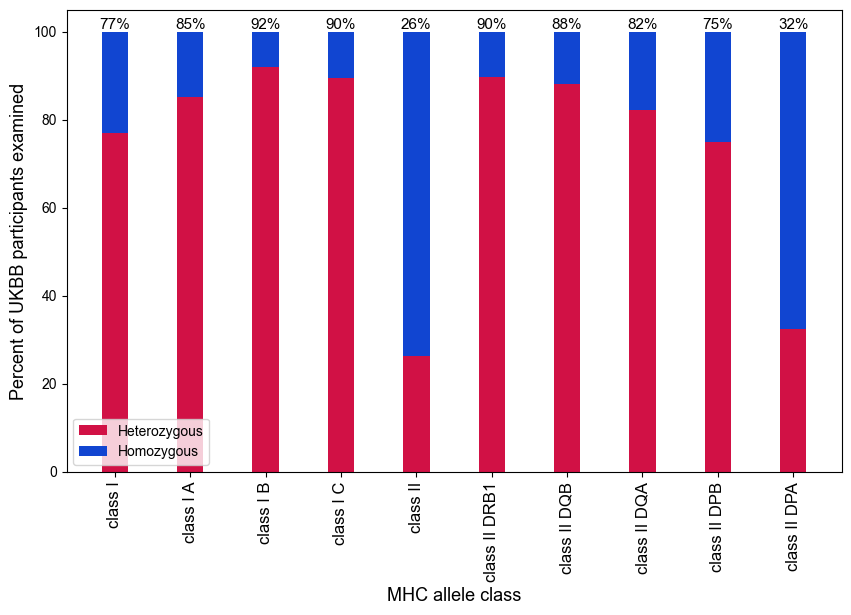

In [27]:

# plotting

colors = ['#D11145', '#1145d1']

plt.figure(figsize=(10, 6))

bar_width = 0.35
bar_positions = range(len(df_percents))
bars_het = plt.bar(bar_positions, df_percents['percent_heterozygous'], color=colors[0], width=bar_width, label='Heterozygous') # het at the bottom
bars_hom = plt.bar(bar_positions, df_percents['percent_homozygous'], color=colors[1], width=bar_width, label='Homozygous', bottom=df_percents['percent_heterozygous']) # stack het on hom

plt.xticks(bar_positions, df_percents['label'], fontsize = 12)
plt.xlabel('MHC allele class', fontsize = 13)
plt.ylabel('Percent of UKBB participants examined', fontsize = 13)
plt.xticks(rotation = 90)

for bar1, bar2, percent_1 in zip(bars_het, bars_hom, df_percents['percent_heterozygous']):
    plt.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height() + bar2.get_height(), f'{round(percent_1)}%', 
             ha='center', va='bottom', fontsize=11, color='black')

plt.legend(loc = 'lower left')
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_percent_heterozygous_across_MHC_allele_classes.pdf', bbox_inches='tight')

# got ~the same thing as the Krishna et al. 2024 Science paper (they have a typo in class II DPB)


In [28]:
df_counts1 = df_clean_hla1.count_class_I.value_counts().reset_index()
df_counts2 = df_clean_hla2.count_class_II_drb.value_counts().reset_index().sort_values(by = 'count_class_II_drb')

# add percentage values
df_counts1['percent'] = df_counts1['count'] / df_counts1['count'].sum() * 100
df_counts2['percent'] = df_counts2['count'] / df_counts2['count'].sum() * 100

df_counts1 = df_counts1.sort_values(by = 'count_class_I', ascending = True).reset_index()
df_counts2 = df_counts2.sort_values(by = 'count_class_II_drb', ascending = True).reset_index()


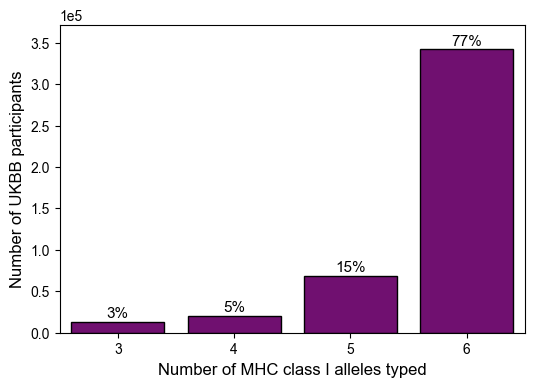

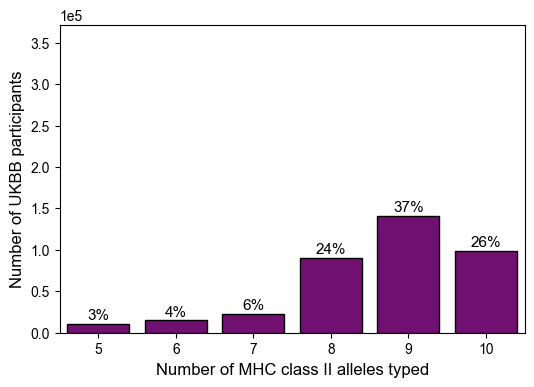

In [29]:
# plot distribution of the number of alleles in class I and class II (how many people have 4/5/6 or 8/9/10)
# note that here you are only considering people who were correctly genotyped in all variants

# plot for MHC class I 
plt.figure(figsize = (6, 4))
sns.barplot(data = df_counts1, x = 'count_class_I', y = 'count', color = 'purple', edgecolor = 'black')
# plt.yscale('log')

plt.xlabel('Number of MHC class I alleles typed', fontsize = 12)
plt.ylabel('Number of UKBB participants', fontsize = 12)

plt.ylim(0, df_counts1['count'].max() + 30000)

plt.xticks(fontsize=10)  
plt.yticks(fontsize=10)

for i, count in enumerate(df_counts1['count_class_I'].tolist()):
    percent = df_counts1['count'][i] / df_counts1['count'].sum() * 100 
    percent = round(percent, 0).astype(int)
    plt.text(i, df_counts1.iloc[i,2] + 10000, f'{percent}%', ha='center', va='center', fontsize=11, color = 'black')

plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_allele_distribution_mhc_classi.pdf', bbox_inches='tight')

# plot for MHC class II
plt.figure(figsize = (6, 4))
sns.barplot(data = df_counts2, x = 'count_class_II_drb', y = 'count', color = 'purple', edgecolor = 'black')
# plt.yscale('log')

plt.xlabel('Number of MHC class II alleles typed', fontsize = 12)
plt.ylabel('Number of UKBB participants', fontsize = 12)

plt.ylim(0, df_counts1['count'].max() + 30000)

plt.xticks(fontsize=10)  
plt.yticks(fontsize=10)

for i, count in enumerate(df_counts2['count_class_II_drb'].tolist()):
    percent = df_counts2['count'][i] / df_counts2['count'].sum() * 100 
    percent = round(percent, 0).astype(int)
    plt.text(i, df_counts2.iloc[i,2] + 10000, f'{percent}%', ha='center', va='center', fontsize=11, color = 'black')

plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_allele_distribution_mhc_classii.pdf', bbox_inches='tight')


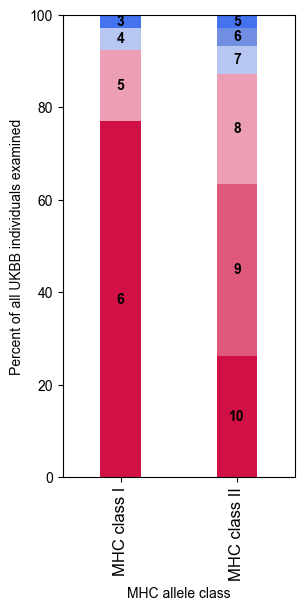

In [30]:

colors1 = ['#D11145', '#ec9fb4', '#b7c7f1', '#4573EF']
colors2 = ['#D11145', '#DE587C', '#ec9fb4', '#b7c7f1', '#708fe3', '#4573EF']

# okay now let's convert this to the stacked barplot 
plt.figure(figsize=(3, 6))

# plt.xticks(bar_positions, df_counts1['count_class_I'])
plt.xlabel('MHC allele class')
plt.ylabel('Percent of all UKBB individuals examined')
plt.xticks(rotation = 90)
plt.ylim(0, 100)

bar_width = 0.35
bar_positions = [0, 1]
bars1_6 = plt.bar(0, df_counts1['percent'][3], color=colors1[0], width=bar_width, label='6 alleles') # het at the bottom
bars1_5 = plt.bar(0, df_counts1['percent'][2], color=colors1[1], width=bar_width, label='5 alleles', bottom = df_counts1['percent'][3]) # het at the bottom
bars1_4 = plt.bar(0, df_counts1['percent'][1], color=colors1[2], width=bar_width, label='4 alleles', bottom = df_counts1['percent'][3] + df_counts1['percent'][2]) # het at the bottom
bars1_3 = plt.bar(0, df_counts1['percent'][0], color=colors1[3], width=bar_width, label='3 alleles', bottom = df_counts1['percent'][3] + df_counts1['percent'][2] + df_counts1['percent'][1]) # het at the bottom

bars2_10 = plt.bar(1, df_counts2['percent'][5], color=colors2[0], width=bar_width, label='10 alleles') # het at the bottom
bars2_9 = plt.bar(1, df_counts2['percent'][4], color=colors2[1], width=bar_width, label='9 alleles', bottom = df_counts2['percent'][5]) # het at the bottom
bars2_8 = plt.bar(1, df_counts2['percent'][3], color=colors2[2], width=bar_width, label='8 alleles', bottom = df_counts2['percent'][5] + df_counts2['percent'][4]) # het at the bottom
bars2_7 = plt.bar(1, df_counts2['percent'][2], color=colors2[3], width=bar_width, label='7 alleles', bottom = df_counts2['percent'][5] + df_counts2['percent'][4] + df_counts2['percent'][3]) # het at the bottom
bars2_6 = plt.bar(1, df_counts2['percent'][1], color=colors2[4], width=bar_width, label='6 alleles', bottom = df_counts2['percent'][5] + df_counts2['percent'][4] + df_counts2['percent'][3] + df_counts2['percent'][2]) # het at the bottom
bars2_5 = plt.bar(1, df_counts2['percent'][0], color=colors2[5], width=bar_width, label='5 alleles', bottom = df_counts2['percent'][5] + df_counts2['percent'][4] + df_counts2['percent'][3] + df_counts2['percent'][2] + df_counts2['percent'][1]) # het at the bottom

plt.text(0, df_counts1['percent'][3]/2, '6', ha='center', va='center', fontsize=10, fontweight = 'bold')
plt.text(0, df_counts1['percent'][3] + df_counts1['percent'][2]/2, '5', ha='center', va='center', fontsize=10, fontweight = 'bold')
plt.text(0, df_counts1['percent'][3] + df_counts1['percent'][2] + df_counts1['percent'][1]/2, '4', ha='center', va='center',fontsize=10, fontweight = 'bold')
plt.text(0, df_counts1['percent'][3] + df_counts1['percent'][2] + df_counts1['percent'][1] + df_counts1['percent'][0]/2, '3', ha='center', va='center', fontsize=10, fontweight = 'bold')

plt.text(1, df_counts2['percent'][5]/2, '10', ha='center', va='center', fontsize=10, fontweight = 'bold')
plt.text(1, df_counts2['percent'][5] + df_counts2['percent'][4]/2, '9', ha='center', va='center', fontsize=10, fontweight = 'bold')
plt.text(1, df_counts2['percent'][5] + df_counts2['percent'][4] + df_counts2['percent'][3]/2, '8', ha='center', va='center', fontsize=10, fontweight = 'bold')
plt.text(1, df_counts2['percent'][5] + df_counts2['percent'][4] + df_counts2['percent'][3] + df_counts2['percent'][2]/2, '7', ha='center', va='center', fontsize=10, fontweight = 'bold')
plt.text(1, df_counts2['percent'][5] + df_counts2['percent'][4] + df_counts2['percent'][3] + df_counts2['percent'][2] + df_counts2['percent'][1]/2, '6', ha='center', va='center', fontsize=10, fontweight = 'bold')
plt.text(1, df_counts2['percent'][5] + df_counts2['percent'][4] + df_counts2['percent'][3] + df_counts2['percent'][2] + df_counts2['percent'][1] + df_counts2['percent'][0]/2 , '5', ha='center', va='center', fontsize=10, fontweight = 'bold')

plt.xticks([0,1], ['MHC class I', 'MHC class II'], fontsize = 12)
plt.xlim(-0.5, 1.5)

plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_percent_heterozygous_across_MHC_allele_classes_split_by_nr.pdf', bbox_inches='tight')


# Add MHC class I divergence scores to UKBB participants

In [31]:
# subset the dataset to only include alleles present, heterozygote status etc.

df_sub_hla1 = df_clean_hla1.drop(columns=df_clean_hla1.columns[df_clean_hla1.columns.str.startswith(('A_', 'B_', 'C_'))])

# 1 add evolutionary divergence 
hed_data = hed_df_with_ids[['Person_ID', 'HED_A', 'HED_B', 'HED_C']]
hed_data = hed_data.fillna(0)

df_sub_hla1_hed = pd.merge(df_sub_hla1, hed_data, on = 'Person_ID')
df_sub_hla1_hed.head()

,Person_ID,sample_index,allele_I_A,allele_I_B,allele_I_C,het_allele_I_A,het_allele_I_B,het_allele_I_C,count_class_I,sum_class_I,het_all_class_I,het_all_class_I_from_allele,HED_A,HED_B,HED_C
0,2812213,0,A_201,"B_4001, B_4402","C_304, C_501",False,True,True,5,6.0,False,False,0.000000,9.640884,4.237569
1,4860169,1,A_101,"B_801, B_5701","C_602, C_701",False,True,True,5,6.0,False,False,0.000000,14.099448,3.116022
2,3381323,2,"A_2301, A_2402","B_1801, B_5701","C_501, C_602",True,True,True,6,6.0,True,True,1.077348,11.729282,5.524862
3,2805252,3,A_101,"B_702, B_5701","C_602, C_702",False,True,True,5,6.0,False,False,0.000000,14.243094,3.392265
4,1118855,4,"A_201, A_1101","B_5501, B_5701","C_303, C_602",True,True,True,6,6.0,True,True,8.104972,11.082873,7.276243


In [32]:

# 2 add functional divergence (FD, Science 2024)

# format columns
fd_a['allele_1_formatted'] = fd_a['allele_1'].apply(transform_format_from_fd)
fd_a['allele_2_formatted'] = fd_a['allele_2'].apply(transform_format_from_fd)
fd_b['allele_1_formatted'] = fd_b['allele_1'].apply(transform_format_from_fd)
fd_b['allele_2_formatted'] = fd_b['allele_2'].apply(transform_format_from_fd)
fd_c['allele_1_formatted'] = fd_c['allele_1'].apply(transform_format_from_fd)
fd_c['allele_2_formatted'] = fd_c['allele_2'].apply(transform_format_from_fd)

# drop rows with repeated combinations (x1 and x2 / x2 and x1)
def sort_values(row):
    sorted_values = sorted([row['allele_1_formatted'], row['allele_2_formatted']])
    return ','.join(sorted_values)

# identify allele combinations and sort (so that x1 always before x2)
fd_a['sorted_alleles'] = fd_a.apply(sort_values, axis=1)
fd_b['sorted_alleles'] = fd_b.apply(sort_values, axis=1)
fd_c['sorted_alleles'] = fd_c.apply(sort_values, axis=1)

# drop rows with a repeated combination of alleles 
fd_a = fd_a.drop_duplicates(subset='sorted_alleles', keep='first')
fd_b = fd_b.drop_duplicates(subset='sorted_alleles', keep='first')
fd_c = fd_c.drop_duplicates(subset='sorted_alleles', keep='first')

# create a corresponding column to merge on
fd_a['allele_I_A'] = fd_a['allele_1_formatted'] + ',' + fd_a['allele_2_formatted'] 
fd_b['allele_I_B'] = fd_b['allele_1_formatted'] + ',' + fd_b['allele_2_formatted'] 
fd_c['allele_I_C'] = fd_c['allele_1_formatted'] + ',' + fd_c['allele_2_formatted'] 

# make sure allele combinations are alphabetically sorted
fd_a['allele_I_A'] = fd_a['allele_I_A'].sort_values()
fd_b['allele_I_B'] = fd_b['allele_I_B'].sort_values()
fd_c['allele_I_C'] = fd_c['allele_I_C'].sort_values()

# subset required data 
fd_a_sub = fd_a[['allele_I_A', 'FD']]
fd_b_sub = fd_b[['allele_I_B', 'FD']]
fd_c_sub = fd_c[['allele_I_C', 'FD']]

# rename columns so we know which FD score corresponds to which class
fd_a_sub = fd_a_sub.rename(columns={'FD': 'FD_A'})
fd_b_sub = fd_b_sub.rename(columns={'FD': 'FD_B'})
fd_c_sub = fd_c_sub.rename(columns={'FD': 'FD_C'})

# because of how HLA are typed in the df_clean_hla1 dataframe, it would be better to drop the second allele if alleles are the same
def process_value(value):

    # identify two alleles present 
    value1 = value.split(',')[0]
    value2 = value.split(',')[1]   
    
    if value1 == value2: # if values the same, only retain the first one 
        return value1
    else: # if values different, keep both
        return value

fd_a['allele_comb'] = fd_a['allele_1_formatted'] + '-' + fd_a['allele_2_formatted']
fd_b['allele_comb'] = fd_b['allele_1_formatted'] + '-' + fd_b['allele_2_formatted']
fd_c['allele_comb'] = fd_c['allele_1_formatted'] + '-' + fd_c['allele_2_formatted']


# Apply the function to the column
fd_a_sub['allele_I_A'] = fd_a_sub['allele_I_A'].apply(process_value)
fd_b_sub['allele_I_B'] = fd_b_sub['allele_I_B'].apply(process_value)
fd_c_sub['allele_I_C'] = fd_c_sub['allele_I_C'].apply(process_value)
fd_a_sub


,allele_I_A,FD_A
0,A_101,0.000000
1,A_201,0.000000
2,A_202,0.000000
3,A_203,0.000000
4,A_204,0.000000
...,...,...
951,"A_203,A_3402",0.960000
953,"A_207,A_7401",0.962264
955,"A_207,A_1101",0.962963
957,"A_207,A_1102",0.963636


In [33]:

# sort allele names alphabetically so they match combinations in FD dataset
df_sub_hla1_hed['allele_I_A'] = df_sub_hla1_hed['allele_I_A'].sort_values()
df_sub_hla1_hed['allele_I_B'] = df_sub_hla1_hed['allele_I_B'].sort_values()
df_sub_hla1_hed['allele_I_C'] = df_sub_hla1_hed['allele_I_C'].sort_values()


In [34]:

# merge the datasets 
df_sub_hla1_hed_fda = pd.merge(df_sub_hla1_hed, fd_a_sub, on = 'allele_I_A', how='left')
# btw df_sub_hla1_hed_fda.isna().sum() > we dont have the FD for most of combinations (bit weird they don't provide it?)
df_sub_hla1_hed_fdb = pd.merge(df_sub_hla1_hed_fda, fd_b_sub, on = 'allele_I_B', how = 'left')
df_sub_hla1_hed_fdall = pd.merge(df_sub_hla1_hed_fdb, fd_c_sub, on = 'allele_I_C', how = 'left')


In [35]:
# add functional divergence (from NetMHC)

# create a corresponding column to merge on
netmhc_a_scores_df_sub['allele_I_A'] = netmhc_a_scores_df_sub['allele_1'] + ',' + netmhc_a_scores_df_sub['allele_2']
netmhc_b_scores_df_sub['allele_I_B'] = netmhc_b_scores_df_sub['allele_1'] + ',' + netmhc_b_scores_df_sub['allele_2']
netmhc_c_scores_df_sub['allele_I_C'] = netmhc_c_scores_df_sub['allele_1'] + ',' + netmhc_c_scores_df_sub['allele_2']

# subset required data 
net_a_scores_sub = netmhc_a_scores_df_sub[['allele_I_A', 'NetMHC_score']]
net_b_scores_sub = netmhc_b_scores_df_sub[['allele_I_B', 'NetMHC_score']]
net_c_scores_sub = netmhc_c_scores_df_sub[['allele_I_C', 'NetMHC_score']]

# rename columns so we know which FD score corresponds to which class
net_a_scores_sub = net_a_scores_sub.rename(columns={'NetMHC_score': 'NetMHC_score_A'})
net_b_scores_sub = net_b_scores_sub.rename(columns={'NetMHC_score': 'NetMHC_score_B'})
net_c_scores_sub = net_c_scores_sub.rename(columns={'NetMHC_score': 'NetMHC_score_C'})

# merge with the dataset we have
df_sub_hla1_hed_fd_neta = pd.merge(df_sub_hla1_hed_fdall, net_a_scores_sub, on = 'allele_I_A', how = 'left')
df_sub_hla1_hed_fd_netb = pd.merge(df_sub_hla1_hed_fd_neta, net_b_scores_sub, on = 'allele_I_B', how = 'left')
df_sub_hla1_hed_fd_netall = pd.merge(df_sub_hla1_hed_fd_netb, net_c_scores_sub, on = 'allele_I_C', how = 'left')


/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_59305/837289506.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  netmhc_a_scores_df_sub['allele_I_A'] = netmhc_a_scores_df_sub['allele_1'] + ',' + netmhc_a_scores_df_sub['allele_2']
/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_59305/837289506.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  netmhc_b_scores_df_sub['allele_I_B'] = netmhc_b_scores_df_sub['allele_1'] + ',' + netmhc_b_scores_df_sub['allele_2']
/var/folders/pm/9pk2smx1

# Add phenotype + outcome data (cancer)

In [36]:

# load datasets with phenotypic data (dataset from Hamish McGregor, sent on 28/02/2024)

pheno_df = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/pheno_info20230504.tsv', sep = '\t')
ancestry_df = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_iadmix_ancestry_props.csv')

# make sure we have consistent naming for Person_ID column 
pheno_df = pheno_df.rename(columns={'ID_v0': 'Person_ID'}) 
ancestry_df = ancestry_df.rename(columns={'ukbid': 'Person_ID'}) 

# clean up datasets: IDs < 0 participants resigned from the study 
pheno_df = pheno_df[pheno_df.Person_ID > 0] # only retain participants with IDs greater than 0
ancestry_df = ancestry_df[ancestry_df.Person_ID > 0] # only retain participants with IDs greater than 0

# check how many people you have the data for
ids_pheno_data = pheno_df.Person_ID.unique()
ids_ancestry_data = ancestry_df.Person_ID.unique()

print('Number of people with phenotypic data available:', len(ids_pheno_data))
print('Number of people with ancestry data available:', len(ids_ancestry_data))

# identify people for whom both are available
ids_pheno_ancestry = set(ids_pheno_data).intersection(set(ids_ancestry_data)) # intersection 
print('Number of people with phenotypic and ancestry data available:', len(ids_pheno_ancestry))

ids_pheno_ancestry_mhc = set(ids_pheno_ancestry).intersection(set(ids_mhc1_mhc2)) # intersection 
print('Number of people with phenotypic and ancestry data available AND with correctly genotyped MHC I and II:', len(ids_pheno_ancestry_mhc))


/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_59305/3526144958.py:3: DtypeWarning: Columns (62,78,79,87,93,94,101,104,105,106,219,221,242,247,248,249,256,259,260,265,268,361,363,387,388,393,397,398,405,408,471,472,473,474,483,484,485,486,495,496,497,498,500,501,506,507,512,513) have mixed types. Specify dtype option on import or set low_memory=False.
  pheno_df = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/pheno_info20230504.tsv', sep = '\t')


Number of people with phenotypic data available: 502368
Number of people with ancestry data available: 502603
Number of people with phenotypic and ancestry data available: 502366
Number of people with phenotypic and ancestry data available AND with correctly genotyped MHC I and II: 346796


In [37]:

# create ancestry main column
ancestry_df_main = ancestry_df[['Person_ID', 'iadmix_main_ancestry_v2']]

ancestry_df_main['iadmix_main_ancestry_v2'] = pd.Categorical(ancestry_df_main['iadmix_main_ancestry_v2']) 
admix_dummies = pd.get_dummies(ancestry_df_main['iadmix_main_ancestry_v2'])
admix_dummies = admix_dummies.astype(int)
admix_df = pd.concat([ancestry_df_main, admix_dummies], axis=1)
admix_df = admix_df.drop('iadmix_main_ancestry_v2', axis = 1)
admix_df

/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_59305/562714986.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ancestry_df_main['iadmix_main_ancestry_v2'] = pd.Categorical(ancestry_df_main['iadmix_main_ancestry_v2'])


,Person_ID,AFR,EAS,EUR,Mixed,SAS
13,1000017,0,0,1,0,0
14,1000025,0,0,1,0,0
15,1000038,0,0,1,0,0
16,1000042,0,0,1,0,0
17,1000056,0,0,1,0,0
...,...,...,...,...,...,...
502611,6026161,0,0,1,0,0
502612,6026174,0,0,1,0,0
502613,6026189,0,0,1,0,0
502614,6026193,0,0,1,0,0


## Cancer outcomes

In [38]:
# for phenotype, we will be looking at the first.diagnosed.cancer.type1 column
# this contains ICD-10 cancer codes 
# load the dataset with code descriptors
cancer_codes_desc = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/cancer_codes_desc.csv')
cancer_codes_desc

,ICD_code,description,classification
0,C00,oral cancer,head_and_neck
1,C01,oral cancer,head_and_neck
2,C02,oral cancer,head_and_neck
3,C03,oral cancer,head_and_neck
4,C04,oral cancer,head_and_neck
...,...,...,...
85,C94,leukemia,lymphatic_hematopoietic
86,C95,leukemia,lymphatic_hematopoietic
87,C96,non-Hodgkin lymphoma,lymphatic_hematopoietic
88,C97,unclassified,other


In [39]:

# what cancers to look at: get codes of cancers which are most common (top 25?)
cancer_counts = pheno_df['first.diagnosed.cancer.type1'].value_counts().reset_index() # counts of different cancer codes in the dataset 
cancer_counts.rename(columns = {'first.diagnosed.cancer.type1' : 'ICD_code'}, inplace = True)
cancer_counts_desc = pd.merge(cancer_counts,cancer_codes_desc, on = 'ICD_code')

# # identify cancers with > 1000 cases in the UKBB 
cancers_1000_cases = cancer_counts_desc[cancer_counts_desc['count'] >= 1000]
cancers_1000_cases_ids = cancers_1000_cases.ICD_code.tolist()

# identify top 25 most common cancers in the UKBB  
cancers_top25_cases = cancer_counts_desc.iloc[0:24]
cancers_top25_cases_ids = cancers_top25_cases.ICD_code.tolist()

# # save all counts data, can be useful to look at and compare to the actual name 
# pd.DataFrame(cancer_counts).to_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/cancer_counts_UKBB_diagnosed_histology1.csv')

In [40]:

# create outcome table 

# create a quick dataframe with Patient ID and cancer diagnosis (for 25 most common cancers + any cancer)
cancer_df = pheno_df[['Person_ID', 'first.diagnosed.cancer.type1']]

# change type of code to int > string
cancer_df['first.diagnosed.cancer.type1'] = cancer_df['first.diagnosed.cancer.type1'].astype(str)
cancer_df['first.diagnosed.cancer.type1'].unique()

# now we want to change it such that we have 25 columns with status for a specific cancer + any cancer (ie diangosed not NaN)
# this is quite a funky way of doing it but it work

# 1 if someone has cancer but 
for index, row in cancer_df.iterrows():
    if row['first.diagnosed.cancer.type1'] == 'nan': # do not change NaN values 
        continue
    if row['first.diagnosed.cancer.type1'] not in cancers_top25_cases_ids: # if has other cancer, change to 'other'
         cancer_df.at[index, 'first.diagnosed.cancer.type1'] = 'other'

# convert to categorical column
cancer_df['first.diagnosed.cancer.type1'] = pd.Categorical(cancer_df['first.diagnosed.cancer.type1']) 

# prepare 'dummies dataframe'
cancer_dummies = pd.get_dummies(cancer_df['first.diagnosed.cancer.type1'])

# add column 'has cancer 
cancer_dummies['has_cancer'] = cancer_dummies.iloc[:, -2].replace({True: 0, False: 1})
cancer_dummies = cancer_dummies.astype(int)

# create the complete dataframe 
cancer_df = pd.concat([cancer_df, cancer_dummies], axis=1)

# add age at first cancer diagnosis 
cancer_age_df = pheno_df[['Person_ID', 'first.diagnosed.cancer.type1']]
cancer_df = pd.merge(cancer_df, cancer_age_df, on = 'Person_ID')

# remove the column
cols_to_drop = ['first.diagnosed.cancer.type1_x', 'nan']
cols_to_retain = [x for x in cancer_df.columns.tolist() if x not in cols_to_drop]

# this is our dataframe with features (Age, Sex, Smoking, Ehtnic, BMI, Waist + cancer outcomes)
outcome_df = cancer_df[cols_to_retain]


/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_59305/3553479718.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_df['first.diagnosed.cancer.type1'] = cancer_df['first.diagnosed.cancer.type1'].astype(str)
/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_59305/3553479718.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_df['first.diagnosed.cancer.type1'] = pd.Categorical(cancer_df['first.diagnosed.cancer.type1'])


# Dataframe with phenotype features 

In [41]:

# Select features of interest 

# FEATURES: Age, Sex_v0, Genetic.sex_v0, Ever.smoked_v0, Ethnic.background_v0, Body.maxx,index..BMI._v0, Waist.circumference_v1 

# create age column (age at attending assessment centre)
pheno_df['Year.of.attending.assessment.centre_v0'] = pheno_df['Date.of.attending.assessment.centre_v0'].str.split('-').str[0] # determine year of attending assessment centre
pheno_df['Year.of.attending.assessment.centre_v0'] = pheno_df['Year.of.attending.assessment.centre_v0'].apply(lambda x: int(x) if not pd.isna(x) else x) # convert to int 
pheno_df['Year.of.birth_v0'] = pheno_df['Year.of.birth_v0'].apply(lambda x: int(x) if not pd.isna(x) else x) # convert to int 
pheno_df['Age.of.attending.assessment.centre_v0'] = pheno_df['Year.of.attending.assessment.centre_v0'] - pheno_df['Year.of.birth_v0'] # determine age when attended assessment centre
pheno_df['Age.of.attending.assessment.centre_v0'] = pheno_df['Age.of.attending.assessment.centre_v0'].apply(lambda x: int(x) if not pd.isna(x) else x) # convert to int 

# not sure where on Earth I would get the socio-economic index out from
features = ['Person_ID', 'Age.of.attending.assessment.centre_v0', 'Sex_v0', 'Ever.smoked_v0','Ethnic.background_v0', 'Body.mass.index..BMI._v0', 'Waist.circumference_v1'] 
features_df = pheno_df[features]
features_df

,Person_ID,Age.of.attending.assessment.centre_v0,Sex_v0,Ever.smoked_v0,Ethnic.background_v0,Body.mass.index..BMI._v0,Waist.circumference_v1
0,1000017,65.0,Female,Yes,British,26.9949,NaN
1,1000025,51.0,Female,Yes,British,22.5460,NaN
2,1000038,52.0,Female,No,British,31.5882,NaN
3,1000042,52.0,Male,No,British,29.3210,NaN
4,1000056,65.0,Female,No,British,27.1382,NaN
...,...,...,...,...,...,...,...
502363,6026189,66.0,Female,No,British,29.9548,NaN
502364,6026193,59.0,Female,No,British,30.4491,NaN
502365,6026206,NaN,Male,NaN,NaN,NaN,NaN
502366,6026214,NaN,Female,NaN,NaN,NaN,NaN


In [42]:

# format categorical features correctly

# for binary outcomes, convert to 0 / 1
features_df['Sex_v0'] = features_df['Sex_v0'].replace({'Female': 0, 'Male': 1})
features_df['Ever.smoked_v0'] = features_df['Ever.smoked_v0'].replace({'Yes': 1, 'No': 0})

# for categorical data with no 1 / 0 levels, need to create dummies again 
ethnic_df = features_df[['Person_ID', 'Ethnic.background_v0']]
ethnic_df['Ethnic.background_v0'] = pd.Categorical(ethnic_df['Ethnic.background_v0']) 
ethnic_dummies = pd.get_dummies(ethnic_df['Ethnic.background_v0'])
ethnic_dummies = ethnic_dummies.astype(int) # we want to convert True / False to 1 / 0
ethnic_dummies = ethnic_dummies.drop(['Do not know', 'Prefer not to answer'], axis = 1)
features_df = pd.concat([features_df, ethnic_dummies], axis=1)

features_df = features_df.drop(['Ethnic.background_v0'], axis = 1) # drop columns with incorrect format / that would not be relevant 
features_df

/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_59305/3489109.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['Sex_v0'] = features_df['Sex_v0'].replace({'Female': 0, 'Male': 1})
/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_59305/3489109.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['Ever.smoked_v0'] = features_df['Ever.smoked_v0'].replace({'Yes': 1, 'No': 0})
/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_59305/3489109.py:9: SettingWithC

,Person_ID,Age.of.attending.assessment.centre_v0,Sex_v0,Ever.smoked_v0,Body.mass.index..BMI._v0,Waist.circumference_v1,African,Any other Asian background,Any other Black background,Any other mixed background,...,Chinese,Indian,Irish,Mixed,Other ethnic group,Pakistani,White,White and Asian,White and Black African,White and Black Caribbean
0,1000017,65.0,0,1.0,26.9949,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1000025,51.0,0,1.0,22.5460,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1000038,52.0,0,0.0,31.5882,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1000042,52.0,1,0.0,29.3210,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1000056,65.0,0,0.0,27.1382,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502363,6026189,66.0,0,0.0,29.9548,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
502364,6026193,59.0,0,0.0,30.4491,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
502365,6026206,NaN,1,NaN,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
502366,6026214,NaN,0,NaN,NaN,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:

# next, you need to add ancestry (admixture) data to this 
features_df = pd.merge(features_df, admix_df, on = 'Person_ID')

# next, you want to add HLA class I features
df_sub_hla1_hed_bool = df_sub_hla1_hed.replace({False: 0, True: 1}) # replace True / False with 1 / 0 to have this more systematically
features_df_hla1 = pd.merge(features_df, df_sub_hla1_hed_bool, on = 'Person_ID')
features_df_hla1


,Person_ID,Age.of.attending.assessment.centre_v0,Sex_v0,Ever.smoked_v0,Body.mass.index..BMI._v0,Waist.circumference_v1,African,Any other Asian background,Any other Black background,Any other mixed background,...,het_allele_I_A,het_allele_I_B,het_allele_I_C,count_class_I,sum_class_I,het_all_class_I,het_all_class_I_from_allele,HED_A,HED_B,HED_C
0,1000017,65.0,0,1.0,26.9949,NaN,0,0,0,0,...,1,1,1,6,6.0,1,1,3.204420,7.375691,6.491713
1,1000025,51.0,0,1.0,22.5460,NaN,0,0,0,0,...,1,1,1,6,6.0,1,1,6.425414,8.127072,6.640884
2,1000038,52.0,0,0.0,31.5882,NaN,0,0,0,0,...,1,1,1,6,6.0,1,1,8.104972,7.928177,5.524862
3,1000042,52.0,1,0.0,29.3210,NaN,0,0,0,0,...,0,1,1,5,6.0,0,0,0.000000,9.414365,7.055249
4,1000056,65.0,0,0.0,27.1382,NaN,0,0,0,0,...,1,1,1,6,6.0,1,1,6.640884,14.331492,4.762431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443391,6026156,68.0,1,1.0,25.8883,NaN,0,0,0,0,...,1,1,1,6,6.0,1,1,10.502762,9.696133,6.149171
443392,6026161,68.0,0,1.0,21.1127,NaN,0,0,0,0,...,1,1,1,6,6.0,1,1,5.745856,4.679558,1.314917
443393,6026174,66.0,1,1.0,25.4268,NaN,0,0,0,0,...,1,1,1,6,6.0,1,1,10.696133,8.613260,3.464088
443394,6026189,66.0,0,0.0,29.9548,NaN,0,0,0,0,...,1,1,1,6,6.0,1,1,8.303867,7.751381,2.839779


In [44]:

# create a combined df with features and outcome
combined_df = pd.merge(features_df_hla1, outcome_df, on = 'Person_ID')
print('Number of observations:', combined_df.shape[0])
combined_df = combined_df.iloc[:,:-1]
combined_df.head()


Number of observations: 443396


,Person_ID,Age.of.attending.assessment.centre_v0,Sex_v0,Ever.smoked_v0,Body.mass.index..BMI._v0,Waist.circumference_v1,African,Any other Asian background,Any other Black background,Any other mixed background,...,C73,C82,C83,C85,C90,C91,C92,D05,other,has_cancer
0,1000017,65.0,0,1.0,26.9949,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1000025,51.0,0,1.0,22.5460,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1000038,52.0,0,0.0,31.5882,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1000042,52.0,1,0.0,29.3210,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1000056,65.0,0,0.0,27.1382,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Add CH status (for 20 variants)

### note: we do not have CH screening results for 80% of the UKBB cohort
you need to subset for people you actually looked at 

In [45]:


# next, add the CH status outcome  
folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls_annotated'  # Path to ukb files from Hamish 

# Get all files in the folder 
files = glob.glob(os.path.join(folder_path, '*.txt'))  
# print('Files examined are:', files)

# Initialize an empty dictionary 
dataframes = {}

# Iterate through the CSV files and read each one with pandas
for csv_file in files:
    
    df = pd.read_csv(csv_file, sep = '\t')
    dataframes[csv_file] = df

# Extract dataframes 
for file_name, df in dataframes.items():
    
    variable_name = file_name.split('/')[8].split('.')[0] + '_data'  # Removing the file extension
    print('Examined file:', variable_name)
    
    df['batch'] = variable_name # add column to indicate source 
    globals()[variable_name] = df  # assign dataframe to the variable 


# Concat all into one df
dfs_to_concat = [v for k, v in globals().items() if k.endswith('_data') and isinstance(v, pd.DataFrame)]

# Row bind all batch dataframes into a single one 
batch_all = pd.concat(dfs_to_concat, ignore_index=True)
batch_all = batch_all.dropna(subset=['batch']) # remove rows which are read incorrectly (w/o batch number)

print('Number of samples with variants examined:', batch_all.shape[0])


Examined file: batch_21_annotated_data
Examined file: batch_18_annotated_data
Examined file: batch_15_annotated_data
Examined file: batch_11_annotated_data
Examined file: batch_16_annotated_data
Examined file: batch_12_annotated_data
Examined file: batch_13_annotated_data
Examined file: batch_17_annotated_data
Examined file: batch_14_annotated_data
Examined file: batch_19_annotated_data
Examined file: batch_20_annotated_data
Number of samples with variants examined: 76718


In [46]:

# Change numerical variables to integers

batch_all['end_position'] = batch_all['end_position'].astype(int)
batch_all['position'] = batch_all['position'].astype(int)
batch_all['sample_ID'] = batch_all['sample_ID'].astype(int)

# Subset and create new useful columns

batch_all = batch_all[['sample_ID', 'chromosome', 'end_position', 'VAF', 'var_depth', 'depth', 'Amino_acids', 'SYMBOL', 'Codons', 'batch']]
batch_all['alt_variant'] = batch_all['Amino_acids'].str.split('/', expand = True)[1] # alternative (CH) variant
batch_all['ref_variant'] = batch_all['Amino_acids'].str.split('/', expand = True)[0] # reference variant 

# There are some cases where there is no change in amino acids, for now save as NaN 

batch_all['alt_variant'].fillna(batch_all['Amino_acids'], inplace=True)
batch_all['ref_variant'].fillna(batch_all['Amino_acids'], inplace=True)

# Exclude data with singletons (likely errors)

batch_all_ns = batch_all[batch_all['var_depth'] >= 2]

# Number of samples with two variant reads or more 
print('Number of samples carrying more than a single read with the variant sequence:', batch_all_ns.shape[0])
# okay so we have 2823 of these but then note that only 2249 are with CH variants 
# so like 20% of >= 2 reads are not v likely to be real? should conslut with Jamie 

batch_all_ns.head(n = 10)

Number of samples carrying more than a single read with the variant sequence: 2823


,sample_ID,chromosome,end_position,VAF,var_depth,depth,Amino_acids,SYMBOL,Codons,batch,alt_variant,ref_variant
443661,2100538,chr17,7674894,0.036364,2.0,55.0,R/*,TP53,Cga/Tga,batch_21_annotated_data,*,R
443676,2100679,chr2,25234373,0.048780,4.0,82.0,R/H,DNMT3A,cGc/cAc,batch_21_annotated_data,H,R
443679,2100706,chr2,25234307,0.019417,2.0,103.0,P/L,DNMT3A,cCg/cTg,batch_21_annotated_data,L,P
443684,2100777,chr2,25240313,0.020833,2.0,96.0,R/*,DNMT3A,Cga/Tga,batch_21_annotated_data,*,R
443685,2100788,chr2,25240420,0.131148,8.0,61.0,Y/C,DNMT3A,tAc/tGc,batch_21_annotated_data,C,Y
443703,2101006,chr2,25240420,0.027778,2.0,72.0,Y/S,DNMT3A,tAc/tCc,batch_21_annotated_data,S,Y
443729,2101361,chr17,76736877,0.025641,2.0,78.0,P/H,SRSF2,cCc/cAc,batch_21_annotated_data,H,P
443746,2101637,chr2,25240313,0.021739,2.0,92.0,R/*,DNMT3A,Cga/Tga,batch_21_annotated_data,*,R
443750,2101708,chr17,7675088,0.033898,2.0,59.0,R/H,TP53,cGc/cAc,batch_21_annotated_data,H,R
443774,2102011,chr15,90088702,0.097561,4.0,41.0,R/Q,IDH2,cGg/cAg,batch_21_annotated_data,Q,R


In [47]:

# Import indexes tested in each batch 
folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls/batch_ids'  # Path to ukb files from Hamish 

# Get all files in the folder 
files_ids = glob.glob(os.path.join(folder_path, '*.tsv'))  

# Read each file one by one 

indexes = {}

# Iterate through the CSV files and read each one with pandas
for file in files_ids:
    
    id = pd.read_csv(file, sep = '\t')
    id = id.rename(columns={'batch ID': 'sample_ID'})
    id['sample_ID'] = id['sample_ID'].str.split('_', n = 1).str[0]
    indexes[file] = id

for file_name, df in indexes.items():
    
    variable_name = file_name.split('/')[9].split('.')[0]    # Remove file extension
    globals()[variable_name] = df  # Assign the DataFrame to a variable with the file name


In [48]:

# Find out how many gene_variants were called:

# don't show warnings 
import warnings
warnings.filterwarnings("ignore")

# identify variants called 
batch_all_ns['variant_coord'] = batch_all_ns['chromosome'].astype(str) + "_" + batch_all_ns['end_position'].astype(str) # specific position in the genome 
batch_all_ns['variant_coord'] = batch_all_ns['variant_coord'].astype('category')
batch_all_ns['variant_coord_pos'] = batch_all_ns['variant_coord'].astype(str) +  "_" + batch_all_ns['SYMBOL'].astype(str) + "_" + batch_all_ns['ref_variant'].astype(str) + "_" + batch_all_ns['alt_variant'].astype(str) # change to a specific aa
batch_all_ns['variant_coord_pos'] = batch_all_ns['variant_coord_pos'].astype('category')

# remove samples that have not been annotated (you can tell from the coordinate what is likely but these could be different mutations)
batch_all_ns = batch_all_ns.dropna(subset=['SYMBOL']) # remove column where gene is not known 
print('Number of samples which have been correctly annotated:', batch_all_ns.shape[0]) # but at each site, you are getting reads modified to sth else 
# ok so sth worked wrong with annotation in only 5 cases > that looks good 

# identify the number of variants in a specific position
num_variants = pd.DataFrame(batch_all_ns['variant_coord_pos'].value_counts())
num_variants = num_variants[num_variants['count']!=0]
num_variants = num_variants.sort_values(by = 'count')
num_variants['variant_coord_pos'] = num_variants.index
num_variants = num_variants.reset_index(drop=True)
num_variants = num_variants.sort_values(by = 'variant_coord_pos')
print('Number of variants identified in batches analysed:', num_variants.shape[0]) # but at each site, you are getting reads modiifed to sth else 

# identify the number of positions we looked at
num_sites = pd.DataFrame(batch_all_ns['variant_coord'].value_counts())
num_sites = num_sites[num_sites['count']!=0]
num_sites = num_sites.sort_values(by = 'count')
num_sites['variant_coord'] = num_sites.index
num_sites = num_sites.reset_index(drop=True)
num_sites = num_sites.sort_values(by = 'variant_coord')
print('Number of sites identified in batches analysed:', num_sites.shape[0]) # okay see so you only found 37 sites 


Number of samples which have been correctly annotated: 2818
Number of variants identified in batches analysed: 89
Number of sites identified in batches analysed: 41


In [49]:

# Annotation (using df with variant names and genomic coordinates)

# read in the df with coordinates
coord_gene_var = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ch_variants_coordinates_tp53_added_nts.csv')

# all coordinates identified in the batches  
coord_out = num_sites['variant_coord'].tolist()

# intersection (annotate)
coord_gene_var['variant_coord'] = coord_gene_var['chromosome'] + "_" + coord_gene_var['end_position'].astype(str) # find cariant coordinates
coord_gene_var['SYMBOL'] = coord_gene_var['gene_var'].str.split('_').str[0] # find gene analysed
coord_gene_var['ref_variant'] = coord_gene_var['gene_var'].str.split('_').str[1].str[0] # reference sequence variant 
coord_gene_var['alt_variant'] = coord_gene_var['gene_var'].str.split('_').str[1].str[-1] # alternative sequence (CH / mutation) variant
coord_gene_var['variant_coord_pos'] = coord_gene_var['variant_coord'].astype(str) + "_" + coord_gene_var['SYMBOL'].astype(str) + "_" + coord_gene_var['ref_variant'].astype(str) + "_" + coord_gene_var['alt_variant'].astype(str) # specific mutation 

print('Number of variants which have been investigated:', len(coord_gene_var.variant_coord_pos.unique()))
print('Number of sites which have been investigated:',len(coord_gene_var.variant_coord.unique()))

# NB we removed one variant bc the coordinates were incorrect

# NOTE: 
# TP53_R249S was searched for but not found in any of the batches so far 
# there have been 5 samples identified (in DNMT3A, at 2 different sites) with variants that I did not originally search for 
# in addition, some of the variants were offset by one base (could have been a deletion / insertion)
# this is why we have differences in the number of sites in the two datasets 


Number of variants which have been investigated: 42
Number of sites which have been investigated: 36


In [50]:

# identify CH variants typed in the dataset 
gene_vars = coord_gene_var[['variant_coord_pos', 'gene_var']]

# subset batch df to only include variants which were successfully identified 
batch_gene_vars = pd.merge(batch_all_ns, gene_vars, on = 'variant_coord_pos', how = 'inner')
batch_gene_vars['gene_var'] = batch_gene_vars['gene_var'].astype('category')
batch_gene_vars['gene_var'].value_counts()

gene_vars_count = pd.DataFrame(batch_gene_vars['gene_var'].value_counts())
gene_vars_count['gene_var'] = gene_vars_count.index
gene_vars_count = gene_vars_count.reset_index(drop=True)
gene_vars_sorted = gene_vars_count.sort_values(by = 'count', ascending=False)
variants_to_examine = gene_vars_sorted[gene_vars_sorted['count'] >= 50].gene_var.tolist()

# only consider CH with variants where there are > 50 samples, otherwise dont think the regression is going to be of any use
batch_gene_vars_10 = batch_gene_vars[batch_gene_vars['gene_var'].isin(variants_to_examine)]

print('Number of variants identified with annotations:', gene_vars_sorted.shape[0])
print('Number of variants which are sufficiently common:', len(variants_to_examine))
# so we will have 30 variants to look at bc the rest was not mapped correctly 

print('Number of samples with a mutation in a CH-relevant position (with >2 reads):', batch_all_ns.shape[0])
print('Number of patients with a mutation in a CH-relevant position (with >2 reads):', len(batch_all_ns.sample_ID.unique()))
print('Number of samples with a CH hotspot mutation (with > 2 reads):', batch_gene_vars.shape[0])
print('Number of patients with a CH hotspot mutation (with > 2 reads):', len(batch_gene_vars.sample_ID.unique()))
print('Number of samples with a common CH hotspot mutation (with > 2 reads):', batch_gene_vars_10.shape[0])
print('Number of patients with a common CH hotspot mutation (with > 2 reads):', len(batch_gene_vars_10.sample_ID.unique()))


Number of variants identified with annotations: 32
Number of variants which are sufficiently common: 15
Number of samples with a mutation in a CH-relevant position (with >2 reads): 2818
Number of patients with a mutation in a CH-relevant position (with >2 reads): 2761
Number of samples with a CH hotspot mutation (with > 2 reads): 2249
Number of patients with a CH hotspot mutation (with > 2 reads): 2214
Number of samples with a common CH hotspot mutation (with > 2 reads): 2040
Number of patients with a common CH hotspot mutation (with > 2 reads): 2018


In [51]:
# get a finalized df 

# drop non-EUR cases (because we have very few of these, and they really affect cancer risk in the dataset)
combined_df_eur = combined_df[combined_df['EUR']==1]

# select only the columns you are interested in (so you don't throw away too much data)
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # cancer outcomes

# NOTE: here you are selecting stuff that will be available to you as features
# you DEFINITELY want count of alleles and maybe that's more informative than A / B / C
cols = ['Person_ID', 'Age.of.attending.assessment.centre_v0', 'Sex_v0', 'Ever.smoked_v0', 'count_class_I', 'het_allele_I_A', 'het_allele_I_B', 'het_allele_I_C', 'het_all_class_I', 'HED_A', 'HED_B', 'HED_C', 'other', 'has_cancer'] # other useful features / outcomes
cols.extend(cancer_codes) # combine the two lists together  

# drop NaN values
combined_df_clean = combined_df_eur[cols].dropna()

print('Number of people with complete data (features + outcome) available:', combined_df_clean.shape[0])
combined_df_clean.head(n =5)

Number of people with complete data (features + outcome) available: 421972


,Person_ID,Age.of.attending.assessment.centre_v0,Sex_v0,Ever.smoked_v0,count_class_I,het_allele_I_A,het_allele_I_B,het_allele_I_C,het_all_class_I,HED_A,...,C67,C71,C73,C82,C83,C85,C90,C91,C92,D05
0,1000017,65.0,0,1.0,6,1,1,1,1,3.204420,...,0,0,0,0,0,0,0,0,0,0
1,1000025,51.0,0,1.0,6,1,1,1,1,6.425414,...,0,0,0,0,0,0,0,0,0,0
2,1000038,52.0,0,0.0,6,1,1,1,1,8.104972,...,0,0,0,0,0,0,0,0,0,0
3,1000042,52.0,1,0.0,5,0,1,1,0,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,1000056,65.0,0,0.0,6,1,1,1,1,6.640884,...,0,0,0,0,0,0,0,0,0,0


In [52]:
# add outcome 'has_ch'
ch_cases = batch_gene_vars_10.sample_ID.unique().tolist()
combined_df_clean['has_ch'] = combined_df_clean.Person_ID.isin(ch_cases).astype(int)

In [53]:

# note that we did not screen everyone for CH so to include this we need to subset to people we actually looked at 
# subset the dataframe to only include individuals who were actually screened for CH

batch_all['batch_number'] = batch_all['batch'].apply(lambda x: [int(num) for num in re.findall(r'\d+', x)])
batch_numbers_examined = set(batch_all['batch_number'].sum()) 
print('Batches that were examined for variants:', batch_numbers_examined)

all_dataframes = [f'batch_{i}_ids' for i in range(11, 61)]
selected_ids = []

# Iterate through all df name 
for df_name in all_dataframes:
    number = int(re.search(r'\d+', df_name).group())
    # check if number matches numbers of batches examined 
    if number in batch_numbers_examined:        
        selected_ids.append(globals()[df_name])

ids_examined = pd.concat(selected_ids, ignore_index=True)
print('Number of samples examined for variants:', ids_examined.shape[0])

ids_examined_list = ids_examined['sample_ID'].tolist()
ids_examined_list = [int(id) for id in ids_examined_list]
ids_examined_list = [int(id) for id in ids_examined_list]

combined_df_with_ch = combined_df_clean[combined_df_clean['Person_ID'].isin(ids_examined_list)]

print('Number of people screened for CH (EUR + all data available):', combined_df_with_ch.shape[0])

Batches that were examined for variants: {11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}
Number of samples examined for variants: 99597
Number of people screened for CH (EUR + all data available): 86174


### Prepare df

In [54]:

# rename columns
combined_df_clean.rename(columns = {'Age.of.attending.assessment.centre_v0' : 'Age', 'Sex_v0' : 'Sex', 'Ever.smoked_v0' : 'Ever smoker',
                                    'het_allele_I_A' : 'MHC I A het', 'het_allele_I_B' : 'MHC I B het', 'het_allele_I_C' : 'MHC I C het',
                                    'het_all_class_I' : 'MHC I het (6 alleles)', 'count_class_I' : '# distinct MHC I alleles'}, inplace = True)

# Figuring out logistic regression

### Single feature, single outcome 

In [55]:
# before we do anything, I want to make sure that I understand what I am doing and that it makes sense

# first, subset MHC het and has_cancer and try to see if there is a relationship
df_sub = combined_df_clean[['MHC I het (6 alleles)', 'has_cancer']]
cont_table = pd.crosstab(df_sub['MHC I het (6 alleles)'], df_sub['has_cancer'])
cont_table

has_cancer,0,1
MHC I het (6 alleles),,
0,81509,15984
1,272561,51918


In [56]:
# quick df to see the percentage of cancer caser in both categories 
het_status = [0, 1]
percent_cancer = [15984 / (15984 + 81509) * 100, 51918 / (51918 + 272561) * 100]
df_x = pd.DataFrame([het_status, percent_cancer]).T

# get percentage of people with cancer across different categories
av_percent = (15984 + 51918) / (15984 + 51918 + 81509 + 272561) * 100
hom_percent = 15984 / (15984 + 81509) * 100
het_percent = 51918 / (51918 + 272561) * 100
print('Percent of UKBB participants with cancer diagnosis:', av_percent)
print('Percent of UKBB participants (MHC het) with cancer diagnosis:', het_percent)
print('Percent of UKBB participants (MHC hom) with cancer diagnosis:', hom_percent)

Percent of UKBB participants with cancer diagnosis: 16.09158901538491
Percent of UKBB participants (MHC het) with cancer diagnosis: 16.00041913344161
Percent of UKBB participants (MHC hom) with cancer diagnosis: 16.3950232324372


In [57]:

# calculate odds based on percentage values
odds_av = 16.09158901538491 / (100 - 16.09158901538491)
odds_hom = 16.3950232324372 / (100 - 16.3950232324372)
odds_het = 16.00041913344161 / (100 - 16.00041913344161)

print('Odds (everyone):',  odds_av)
print('Odds (homozygote):',  odds_hom) # here is where we get the odds from 
print('Odds (heterozygote):', odds_het)
print('Odds ratio (heterozygote):', odds_het / odds_hom) # odds ratio is treatment compared to control (here we say het is ~treatment)
print('Odds ratio (heterozygote):', np.exp(-0.029072)) # nb this also works 
 

Odds (everyone): 0.19177563758578814
Odds (homozygote): 0.19610104405648454
Odds (heterozygote): 0.1904821306056259
Odds ratio (heterozygote): 0.9713468458166894
Odds ratio (heterozygote): 0.9713465249990143


In [58]:
# Perform chi-square test
from scipy.stats import chi2_contingency
chi2_stat, p_val, dof, expected_freq = chi2_contingency(cont_table)

print("p-value:", p_val)
print('Observed frequnecies:', cont_table)
print("Expected frequencies:")
expected_freq

p-value: 0.003331496763572531
Observed frequnecies: has_cancer                  0      1
MHC I het (6 alleles)               
0                       81509  15984
1                      272561  51918
Expected frequencies:


array([[ 81804.82712123,  15688.17287877],
       [272265.17287877,  52213.82712123]])

In [59]:
# run logistic regression on just this one feature to see if you get a consistent result and how to analyse this
import statsmodels.api as sm

# now, thing is we have missing data which of course does not seat well with doing regression 
# we should probably think about different options / ways to deal with it 

# prepare features and outcome column 
features = ['MHC I het (6 alleles)'] # allele features
X = df_sub[features]
y = df_sub['has_cancer']

model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
result = model.fit()
intercept = result.params[0]
coefficients = result.params
confint = result.conf_int() # nb I checked the default is 95%
pvalues = result.pvalues
print('Intercept =', intercept)
print('Coefficient for MHC class I HET =', coefficients[1])

Optimization terminated successfully.
         Current function value: 0.441175
         Iterations 6
Intercept = -1.6291252216915981
Coefficient for MHC class I HET = -0.02907166971865925


In [60]:
# okay now let's figure out what the confidence intervals mean and how to show them
lower_conf_hom = np.exp(-1.646080)
upper_conf_hom = np.exp(-1.612171)
print('Odds (hom):', odds_hom)
print('Confidence intervals for odds (hom):', lower_conf_hom, upper_conf_hom)

lower_conf_het = np.exp(-1.6291252216915981+(-0.04845066853290214))
upper_conf_het = np.exp(-1.6291252216915981+(-0.009693))
print('Odds (het):', odds_het)
print('Confidence intervals for odds (het):', lower_conf_het, upper_conf_het)

# now we need to calculate the odds ratio
print('Odds ratio (homozygote):', lower_conf_hom / odds_hom, upper_conf_hom / odds_hom)
print('Odds ratio (heterozygote):', lower_conf_het / odds_hom, upper_conf_het / odds_hom)
# this looks correct to me because it is symmetrical and includes the estimate and this is essentially what we expect

print('Odds ratio (heterozygote):', np.exp(-0.04845066853290214), np.exp(-0.009693))
# okay so again just do the np.exp is the easier way for this 


Odds (hom): 0.19610104405648454
Confidence intervals for odds (hom): 0.19280422175035863 0.19945412878353144
Odds (het): 0.1904821306056259
Confidence intervals for odds (het): 0.18682631505483346 0.19420941920677035
Odds ratio (homozygote): 0.9831881450606846 1.017098760198753
Odds ratio (heterozygote): 0.9527043364492256 0.9903538257084988
Odds ratio (heterozygote): 0.9527043364492339 0.9903538257085073


In [61]:
# define function to get odds ratio
# odds ratio > works for both coefficient and confidence intervals it is literally just exponential of whatever you get from the model 
def calculate_odds_ratio(coef):
    return np.exp(coef)


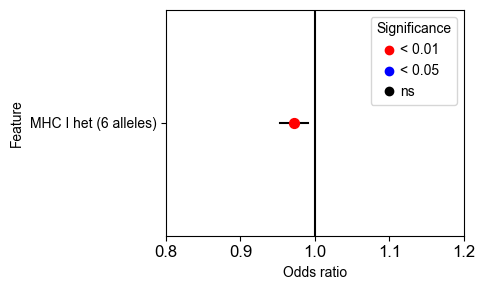

In [62]:

# plot
plt.figure(figsize=(5, 3))

# Calculate odds ratio for the intercept term
intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)
coeff_ods_ratio = calculate_odds_ratio(coefficients[1])

# Get confidence interval for the feature
feature = 'MHC I het (6 alleles)'
log_reg_confint_ri = confint.reset_index()
lower_ci = calculate_odds_ratio(float(log_reg_confint_ri[log_reg_confint_ri['index'] == feature][0]))
upper_ci = calculate_odds_ratio(float(log_reg_confint_ri[log_reg_confint_ri['index'] == feature][1]))
        
# Plot the intercept term
# use color to indicate significance
if pvalues[1] < 0.01:
    color = 'red'
elif pvalues[1] < 0.05:
    color = 'darkblue'
else:
    color = 'red'

# Add legend with significance indicators

plt.scatter(coeff_ods_ratio, features, alpha = 1, s = 50, color = color, zorder = 2, marker='o')
plt.axvline(x = intercept_odds_ratio, color = 'black')
    
plt.xlabel('Odds ratio')
plt.ylabel('Feature')
plt.xlim(0.8, 1.2)
plt.xticks(fontsize = 12)
plt.xticks(fontsize = 12)

# add legend
legend_handles = []
pvalues_list = [0.0001, 0.04, 1]
significance_levels = ['< 0.01', '< 0.05', 'ns']
for p_val, significance_level in zip(pvalues_list, significance_levels):
    # Determine color based on p-value
    if p_val < 0.01:
        color = 'red'
    elif p_val < 0.05:
        color = 'blue'
    else:
        color = 'black'
    
    # Create a proxy artist with the appropriate color
    legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

plt.legend(handles=legend_handles, loc='upper right', title='Significance', handlelength = 0)

# Plot the odds ratio along with its confidence interval
# note: first array is for x coordinates, second array is for y cordinates
plt.plot([lower_ci, upper_ci], [features[0], features[0]], color = 'black', zorder = 1)

plt.tight_layout()
plt.show()


#### Multiple features, single outcome 

In [63]:
# get a crosstab first because I don't get why this looks like this
df_sub2 = combined_df_clean[['MHC I het (6 alleles)', 'MHC I A het', 'MHC I B het', 'MHC I C het', 'has_cancer']]
cont_table_a = pd.crosstab(index=df_sub2['MHC I A het'], columns=df_sub2['has_cancer'], margins=True)
cont_table_b = pd.crosstab(index=df_sub2['MHC I B het'], columns=df_sub2['has_cancer'], margins=True)
cont_table_c = pd.crosstab(index=df_sub2['MHC I C het'], columns=df_sub2['has_cancer'], margins=True)
cont_table_all = pd.crosstab(index=df_sub2['MHC I het (6 alleles)'], columns=df_sub2['has_cancer'], margins=True)

In [64]:
# compare if you do this for more features
features = ['MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)']

for feature in features:
    # first, subset MHC het and has_cancer and try to see if there is a relationship
    df_sub = combined_df_clean[[feature, 'has_cancer']]
    cont_table = pd.crosstab(df_sub[feature], df_sub['has_cancer'])
    
    # percentages with cancer 
    het_status = [0, 1]
    percent_cancer = [cont_table.iloc[0, 1] / cont_table.iloc[0].sum() * 100, cont_table.iloc[1, 1] / cont_table.iloc[1].sum() * 100]
    df_x = pd.DataFrame([het_status, percent_cancer]).T

    av_percent = cont_table.iloc[:, 1].sum() / cont_table.sum().sum() * 100
    hom_percent = cont_table.iloc[0, 1] / cont_table.iloc[0].sum() * 100
    het_percent = cont_table.iloc[1, 1] / cont_table.iloc[1].sum() * 100
    print('Percent of UKBB participants with cancer:', av_percent)
    print(f'Percent of UKBB participants {feature} 1 with cancer:', het_percent)
    print(f'Percent of UKBB participants {feature} 0 with cancer:', hom_percent)

    # odds ratio 
    odds_hom = hom_percent / (100 - hom_percent)
    odds_het = het_percent / (100 - het_percent)
    print('Odds (homozygote):',  odds_hom) # here is where we get the odds from 
    print('Odds (heterozygote):', odds_het)
    print('Odds ratio:', odds_het / odds_hom)
    

Percent of UKBB participants with cancer: 16.09158901538491
Percent of UKBB participants MHC I A het 1 with cancer: 16.061590186228216
Percent of UKBB participants MHC I A het 0 with cancer: 16.259806147534565
Odds (homozygote): 0.19416967407767532
Odds (heterozygote): 0.1913497077424141
Odds ratio: 0.9854767931776354
Percent of UKBB participants with cancer: 16.09158901538491
Percent of UKBB participants MHC I B het 1 with cancer: 16.059133356696695
Percent of UKBB participants MHC I B het 0 with cancer: 16.463126843657815
Odds (homozygote): 0.1970761679437833
Odds (heterozygote): 0.19131483863441706
Odds ratio: 0.970765976579118
Percent of UKBB participants with cancer: 16.09158901538491
Percent of UKBB participants MHC I C het 1 with cancer: 16.043724580655233
Percent of UKBB participants MHC I C het 0 with cancer: 16.502122058055875
Odds (homozygote): 0.19763522696384883
Odds (heterozygote): 0.19109619263741806
Odds ratio: 0.9669136194650821
Percent of UKBB participants with cancer

In [65]:

# prepare features and outcome column 
features = ['MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)'] # allele features
X = combined_df_clean[features]
y = combined_df_clean['has_cancer']

model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
result = model.fit()
intercept = result.params[0]
coefficients = result.params
confint = result.conf_int()
pvalues = result.pvalues
print('Intercept =', intercept)
print('Coefficients =', coefficients)

Optimization terminated successfully.
         Current function value: 0.441172
         Iterations 6
Intercept = -1.644074956408574
Coefficients = const                   -1.644075
MHC I A het              0.031761
MHC I B het              0.003934
MHC I C het              0.002489
MHC I het (6 alleles)   -0.052306
dtype: float64


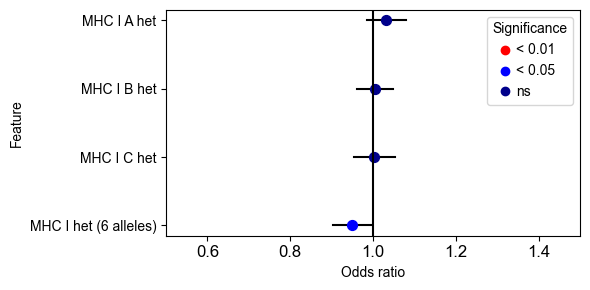

In [66]:

# plot
# initialize figure 
plt.figure(figsize=(6, 3))

# Calculate odds ratio for the intercept term
intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

# Plot the intercept term
# use color to indicate significance

coeff_odds_ratios = []
confint = confint.reset_index()

# Get confidence interval for the feature
for i, feature in enumerate(features):

    # calculate odds ratio when the feature is included 
    coeff_odds_ratio = calculate_odds_ratio(coefficients[i+1])
    coeff_odds_ratios.append(coeff_odds_ratio)

    lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
    upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 

    if pvalues[i+1] < 0.01:
        color = 'red'
    elif pvalues[i+1] < 0.05:
        color = 'blue'
    else:
        color = 'darkblue'
   
    plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 50, color = color, zorder = 2, marker='o')
    plt.plot([lower_ci, upper_ci], [feature, feature], color = 'black', zorder = 1)

plt.axvline(x = intercept_odds_ratio, color = 'black')    
plt.xlabel('Odds ratio')
plt.ylabel('Feature')
plt.xlim(0.5, 1.5)
plt.xticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.gca().invert_yaxis()

# add legend
legend_handles = []
pvalues_list = [0.0001, 0.04, 1]
significance_levels = ['< 0.01', '< 0.05', 'ns']
for p_val, significance_level in zip(pvalues_list, significance_levels):
    # Determine color based on p-value
    if p_val < 0.01:
        color = 'red'
    elif p_val < 0.05:
        color = 'blue'
    else:
        color = 'darkblue'
    
    # Create a proxy artist with the appropriate color
    legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

plt.legend(handles=legend_handles, loc='upper right', title='Significance', handlelength = 0)

# Plot the odds ratio along with its confidence interval
# note: first array is for x coordinates, second array is for y cordinates

plt.tight_layout()
plt.show()


In [67]:

print('Overall:', 67902 / 421972 * 100)
print('Homozygote for all:', 1959 / 12255 * 100)
print('Homozygote for A and B:', 128 / 868 * 100)
print('Homozygote for A and C:', 385 / 2237 * 100)
print('Homozygote for B and C:', 2821 / 16716 * 100)
print('Homozygote for A:', 7912 / 48503 * 100)
print('Homozygote for B:', 673 / 4061 * 100)
print('Homozygote for C:', 2106 / 12853 * 100)

print('Not heterozygote:', (1959 + 128 + 385 + 7912 + 2821 + 673 + 2106) / (12255  + 868 + 2237 + 48503 + 16716 + 4061 + 12853) * 100)
print('Heterozygote for all:', 51918 / 324479 * 100)

print('Nr alleles = 3:', 1959 / 12255 * 100)
print('Nr alleles = 4:', (128 + 385 + 2821) / (868 + 2237 + 16716) * 100)
print('Nr alleles = 5:', (7912 + 673 + 2106) / (48503 + 4061 + 12853) * 100)
print('Nr alleles = 6:', 51918 / 324479 * 100)

Overall: 16.09158901538491
Homozygote for all: 15.985312117503058
Homozygote for A and B: 14.746543778801843
Homozygote for A and C: 17.210549843540456
Homozygote for B and C: 16.87604690117253
Homozygote for A: 16.312393047852712
Homozygote for B: 16.572272839202167
Homozygote for C: 16.385279701237067
Not heterozygote: 16.3950232324372
Heterozygote for all: 16.00041913344161
Nr alleles = 3: 15.985312117503058
Nr alleles = 4: 16.820543867615157
Nr alleles = 5: 16.342846660653958
Nr alleles = 6: 16.00041913344161


Optimization terminated successfully.
         Current function value: 0.441177
         Iterations 5
Intercept = -1.6138052002297028
Coefficients = const         -1.613805
MHC I A het   -0.009876
MHC I B het   -0.002652
MHC I C het   -0.029974
dtype: float64


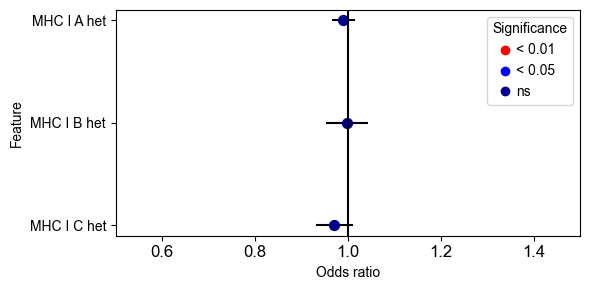

In [68]:

# prepare features and outcome column 
features = ['MHC I A het', 'MHC I B het', 'MHC I C het'] # now try without combined
X = combined_df_clean[features]
y = combined_df_clean['has_cancer']

model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
result = model.fit()
intercept = result.params[0]
coefficients = result.params
confint = result.conf_int()
pvalues = result.pvalues
print('Intercept =', intercept)
print('Coefficients =', coefficients)

# plot
# initialize figure 
plt.figure(figsize=(6, 3))

# Calculate odds ratio for the intercept term
intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

# Plot the intercept term
# use color to indicate significance

coeff_odds_ratios = []
confint = confint.reset_index()
# Get confidence interval for the feature
for i, feature in enumerate(features):

    # calculate odds ratio when the feature is included 
    coeff_odds_ratio = calculate_odds_ratio(coefficients[i+1])
    coeff_odds_ratios.append(coeff_odds_ratio)

    lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
    upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1]))
    
    if pvalues[i+1] < 0.01:
        color = 'red'
    elif pvalues[i+1] < 0.05:
        color = 'blue'
    else:
        color = 'darkblue'
   
    plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 50, color = color, zorder = 2, marker='o')
    plt.plot([lower_ci, upper_ci], [feature, feature], color = 'black', zorder = 1)

plt.axvline(x = intercept_odds_ratio, color = 'black')    
plt.xlabel('Odds ratio')
plt.ylabel('Feature')
plt.xlim(0.5, 1.5)
plt.xticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.gca().invert_yaxis()

# add legend
legend_handles = []
pvalues_list = [0.0001, 0.04, 1]
significance_levels = ['< 0.01', '< 0.05', 'ns']
for p_val, significance_level in zip(pvalues_list, significance_levels):
    # Determine color based on p-value
    if p_val < 0.01:
        color = 'red'
    elif p_val < 0.05:
        color = 'blue'
    else:
        color = 'darkblue'
    
    # Create a proxy artist with the appropriate color
    legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

plt.legend(handles=legend_handles, loc='upper right', title='Significance', handlelength = 0)

# Plot the odds ratio along with its confidence interval
# note: first array is for x coordinates, second array is for y cordinates

plt.tight_layout()
plt.show()


In [69]:
cont_table_ind = pd.crosstab(index=[df_sub2['MHC I A het'], df_sub2['MHC I B het'], df_sub2['MHC I C het']], columns=df_sub2['has_cancer'], margins=True)
cont_table_ind

has_cancer                                0      1     All
MHC I A het MHC I B het MHC I C het                       
0           0           0             10296   1959   12255
                        1               740    128     868
            1           0              1852    385    2237
                        1             40591   7912   48503
1           0           0             13895   2821   16716
                        1              3388    673    4061
            1           0             10747   2106   12853
                        1            272561  51918  324479
All                                  354070  67902  421972

In [70]:
print('Heterozygote for all:', 51918 / 324479 * 100)
print('Homozygote for all:', 1959 / 12255 * 100)
print('Homozygote for A and B:', 128 / 868 * 100)
print('Homozygote for A and C:', 385 / 2237 * 100)
print('Homozygote for B and C:', 2821 / 16716 * 100)
print('Homozygote for A:', 7912 / 48503 * 100)
print('Homozygote for B:', 673 / 4061 * 100)
print('Homozygote for C:', 2106 / 12853 * 100)

Heterozygote for all: 16.00041913344161
Homozygote for all: 15.985312117503058
Homozygote for A and B: 14.746543778801843
Homozygote for A and C: 17.210549843540456
Homozygote for B and C: 16.87604690117253
Homozygote for A: 16.312393047852712
Homozygote for B: 16.572272839202167
Homozygote for C: 16.385279701237067


Optimization terminated successfully.
         Current function value: 0.424139
         Iterations 6
Intercept = -5.633866412176177
Coefficients = const                   -5.633866
Age                      0.066261
Sex                      0.030147
Ever smoker              0.143877
MHC I A het              0.029226
MHC I B het              0.008574
MHC I C het             -0.004382
MHC I het (6 alleles)   -0.048802
dtype: float64


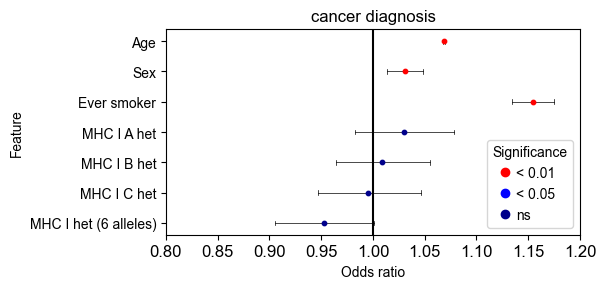

In [71]:

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
features = ['Age', 'Sex', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)'] # allele features
X = combined_df_clean[features]
y = combined_df_clean['has_cancer']

model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
result = model.fit()
intercept = result.params[0]
coefficients = result.params
confint = result.conf_int()
pvalues = result.pvalues
print('Intercept =', intercept)
print('Coefficients =', coefficients)

# plot
# initialize figure 
plt.figure(figsize=(6, 3))
outcome = 'cancer diagnosis'
plt.title(outcome)

# Calculate odds ratio for the intercept term
intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

# Plot the intercept term
# use color to indicate significance

coeff_odds_ratios = []
confint = confint.reset_index()

# Get confidence interval for the feature
for i, feature in enumerate(features):

    # calculate odds ratio when the feature is included 
    coeff_odds_ratio = calculate_odds_ratio(coefficients[i+1])
    coeff_odds_ratios.append(coeff_odds_ratio)

    lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
    upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1]))
    
    if pvalues[i+1] < 0.01:
        color = 'red'
    elif pvalues[i+1] < 0.05:
        color = 'blue'
    else:
        color = 'darkblue'
   
    plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
    plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
    plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
    plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

plt.axvline(x = intercept_odds_ratio, color = 'black')    
plt.xlabel('Odds ratio')
plt.ylabel('Feature')
plt.xlim(0.5, 1.5)
plt.xticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.gca().invert_yaxis()

# add legend
legend_handles = []
pvalues_list = [0.0001, 0.04, 1]
significance_levels = ['< 0.01', '< 0.05', 'ns']
for p_val, significance_level in zip(pvalues_list, significance_levels):
    # Determine color based on p-value
    if p_val < 0.01:
        color = 'red'
    elif p_val < 0.05:
        color = 'blue'
    else:
        color = 'darkblue'
    
    # Create a proxy artist with the appropriate color
    legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

# Plot the odds ratio along with its confidence interval
# note: first array is for x coordinates, second array is for y cordinates

plt.tight_layout()
plt.xlim(0.8, 1.2)
plt.show()

# okay that looks great so we are going to do this for all cancer outcomes 


Optimization terminated successfully.
         Current function value: 0.424143
         Iterations 6
Intercept = -5.605646694837531
Coefficients = const         -5.605647
Age            0.066262
Sex            0.030143
Ever smoker    0.143952
MHC I A het   -0.009627
MHC I B het    0.002319
MHC I C het   -0.034602
dtype: float64


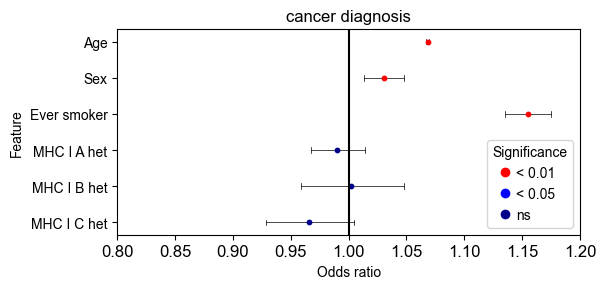

In [72]:
# another thing that is maybe useful if including nr of MHC class I alleles or looking at A / B / C separately
# my personal take is that it is a bit weird to split A / B / C and then do het for all bc these are obviously correlated
# so I think what makes most sense to do is to do one model with het A / B / C and do another with nr distinct alleles sb has 

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
features = ['Age', 'Sex', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het'] # allele features
X = combined_df_clean[features]
y = combined_df_clean['has_cancer']

model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
result = model.fit()
intercept = result.params[0]
coefficients = result.params
confint = result.conf_int()
pvalues = result.pvalues
print('Intercept =', intercept)
print('Coefficients =', coefficients)

# plot
# initialize figure 
plt.figure(figsize=(6, 3))
outcome = 'cancer diagnosis'
plt.title(outcome)

# Calculate odds ratio for the intercept term
intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

# Plot the intercept term
# use color to indicate significance

coeff_odds_ratios = []
confint = confint.reset_index()

# Get confidence interval for the feature
for i, feature in enumerate(features):

    # calculate odds ratio when the feature is included 
    coeff_odds_ratio = calculate_odds_ratio(coefficients[i+1])
    coeff_odds_ratios.append(coeff_odds_ratio)

    lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
    upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1]))
    
    if pvalues[i+1] < 0.01:
        color = 'red'
    elif pvalues[i+1] < 0.05:
        color = 'blue'
    else:
        color = 'darkblue'
   
    plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
    plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
    plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
    plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

plt.axvline(x = intercept_odds_ratio, color = 'black')    
plt.xlabel('Odds ratio')
plt.ylabel('Feature')
plt.xlim(0.5, 1.5)
plt.xticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.gca().invert_yaxis()

# add legend
legend_handles = []
pvalues_list = [0.0001, 0.04, 1]
significance_levels = ['< 0.01', '< 0.05', 'ns']
for p_val, significance_level in zip(pvalues_list, significance_levels):
    # Determine color based on p-value
    if p_val < 0.01:
        color = 'red'
    elif p_val < 0.05:
        color = 'blue'
    else:
        color = 'darkblue'
    
    # Create a proxy artist with the appropriate color
    legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

# Plot the odds ratio along with its confidence interval
# note: first array is for x coordinates, second array is for y cordinates

plt.tight_layout()
plt.xlim(0.8, 1.2)
plt.show()

# okay that looks great so we are going to do this for all cancer outcomes 


Optimization terminated successfully.
         Current function value: 0.424144
         Iterations 6
Intercept = -5.559482729098935
Coefficients = const                      -5.559483
Age                         0.066261
Sex                         0.030132
Ever smoker                 0.143958
# distinct MHC I alleles   -0.014674
dtype: float64


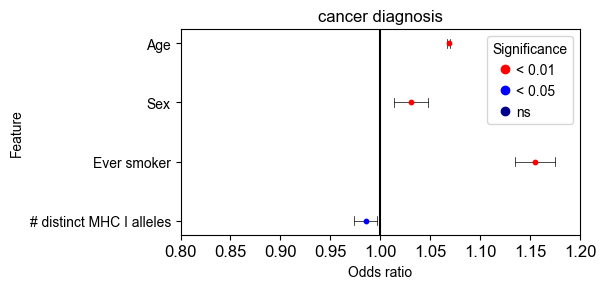

In [73]:
# another thing that is maybe useful if including nr of MHC class I alleles or looking at A / B / C separately
# my personal take is that it is a bit weird to split A / B / C and then do het for all bc these are obviously correlated
# so I think what makes most sense to do is to do one model with het A / B / C and do another with nr distinct alleles sb has 

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
features = ['Age', 'Sex', 'Ever smoker', '# distinct MHC I alleles'] # allele features
X = combined_df_clean[features]
y = combined_df_clean['has_cancer']

model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
result = model.fit()
intercept = result.params[0]
coefficients = result.params
confint = result.conf_int()
pvalues = result.pvalues
print('Intercept =', intercept)
print('Coefficients =', coefficients)

# plot
# initialize figure 
plt.figure(figsize=(6, 3))
outcome = 'cancer diagnosis'
plt.title(outcome)

# Calculate odds ratio for the intercept term
intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

# Plot the intercept term
# use color to indicate significance

coeff_odds_ratios = []
confint = confint.reset_index()

# Get confidence interval for the feature
for i, feature in enumerate(features):

    # calculate odds ratio when the feature is included 
    coeff_odds_ratio = calculate_odds_ratio(coefficients[i+1])
    coeff_odds_ratios.append(coeff_odds_ratio)

    lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
    upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1]))
    
    if pvalues[i+1] < 0.01:
        color = 'red'
    elif pvalues[i+1] < 0.05:
        color = 'blue'
    else:
        color = 'darkblue'
   
    plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
    plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
    plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
    plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

plt.axvline(x = intercept_odds_ratio, color = 'black')    
plt.xlabel('Odds ratio')
plt.ylabel('Feature')
plt.xlim(0.5, 1.5)
plt.xticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.gca().invert_yaxis()

# add legend
legend_handles = []
pvalues_list = [0.0001, 0.04, 1]
significance_levels = ['< 0.01', '< 0.05', 'ns']
for p_val, significance_level in zip(pvalues_list, significance_levels):
    # Determine color based on p-value
    if p_val < 0.01:
        color = 'red'
    elif p_val < 0.05:
        color = 'blue'
    else:
        color = 'darkblue'
    
    # Create a proxy artist with the appropriate color
    legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

plt.legend(handles=legend_handles, loc='upper right', title='Significance', handlelength = 0)

# Plot the odds ratio along with its confidence interval
# note: first array is for x coordinates, second array is for y cordinates

plt.tight_layout()
plt.xlim(0.8, 1.2)
plt.show()

# okay that looks great so we are going to do this for all cancer outcomes 


# Logistic regression MHC I across all cancer outcomes 

## Model 1: MHC I alone

#### MHC A / B / C het

In [130]:

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts = {}
dict_coefficients = {}
dict_confints = {}
dict_pvalues = {}

for outcome in cancer_codes:
    
    # prepare features and outcome
    features = ['MHC I A het', 'MHC I B het', 'MHC I C het'] 
    X = combined_df_clean[features]
    y = combined_df_clean[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0) # silence output (minimize verbosity)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts[outcome] = intercept_multi
    dict_coefficients[outcome] = coeff_multi
    dict_confints[outcome] = confint_multi
    dict_pvalues[outcome] = pvalues_multi


# plot

for outcome_label, coef_dict in dict_coefficients.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    elif outcome_label == 'has_ch':
        descriptor = 'CH diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]
        
    # initialize figure (separate for each outcome)
    plt.figure(figsize=(6, 3))

    # figure out nr of cases:
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []
    
    # find coefficient values 
    coefficients = dict_coefficients[outcome_label][1:] # the first term is intercept so need to skip that 

    # find confidence intervals for the outcome
    confint = dict_confints[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues[outcome_label][1:] # first p value is for the intercept 

    # Get confidence interval for the feature
    features_lm = ['MHC I A het', 'MHC I B het', 'MHC I C het']

    for i, feature in enumerate(features_lm):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1]))
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features_lm[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features_lm[i], features_lm[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_{outcome_label}_mhci_abc.pdf', bbox_inches='tight')
    plt.close()


#### MHC A / B / C het + overall het I status

In [131]:

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts = {}
dict_coefficients = {}
dict_confints = {}
dict_pvalues = {}

for outcome in cancer_codes:
    
    # prepare features and outcome
    features = ['MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)'] 
    X = combined_df_clean[features]
    y = combined_df_clean[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0) # silence output (minimize verbosity)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts[outcome] = intercept_multi
    dict_coefficients[outcome] = coeff_multi
    dict_confints[outcome] = confint_multi
    dict_pvalues[outcome] = pvalues_multi


# plot

for outcome_label, coef_dict in dict_coefficients.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    elif outcome_label == 'has_ch':
        descriptor = 'CH diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]
        
    # initialize figure (separate for each outcome)
    plt.figure(figsize=(6, 3))

    # figure out nr of cases:
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []
    
    # find coefficient values 
    coefficients = dict_coefficients[outcome_label][1:] # the first term is intercept so need to skip that 

    # find confidence intervals for the outcome
    confint = dict_confints[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues[outcome_label][1:] # first p value is for the intercept 

    # Get confidence interval for the feature
    features_lm = ['MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)']

    for i, feature in enumerate(features_lm):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1]))
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features_lm[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features_lm[i], features_lm[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_{outcome_label}_mhci_abc_het.pdf', bbox_inches='tight')
    plt.close()


#### nr of MHC class I alleles 

In [132]:

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts = {}
dict_coefficients = {}
dict_confints = {}
dict_pvalues = {}

for outcome in cancer_codes:
    
    # prepare features and outcome
    features = ['# distinct MHC I alleles'] 
    X = combined_df_clean[features]
    y = combined_df_clean[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0) # silence output (minimize verbosity)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts[outcome] = intercept_multi
    dict_coefficients[outcome] = coeff_multi
    dict_confints[outcome] = confint_multi
    dict_pvalues[outcome] = pvalues_multi


# plot

for outcome_label, coef_dict in dict_coefficients.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    elif outcome_label == 'has_ch':
        descriptor = 'CH diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]
        
    # initialize figure (separate for each outcome)
    plt.figure(figsize=(6, 3))

    # figure out nr of cases:
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []
    
    # find coefficient values 
    coefficients = dict_coefficients[outcome_label][1:] # the first term is intercept so need to skip that 

    # find confidence intervals for the outcome
    confint = dict_confints[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues[outcome_label][1:] # first p value is for the intercept 

    # Get confidence interval for the feature
    features_lm = ['# distinct MHC I alleles'] 

    for i, feature in enumerate(features_lm):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1]))
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features_lm[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features_lm[i], features_lm[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_{outcome_label}_mhci_nr_alleles.pdf', bbox_inches='tight')
    plt.close()


## Model 2: MHC I + add. features (age, sex, smoking)

#### MHC A / B / C het

In [133]:

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts = {}
dict_coefficients = {}
dict_confints = {}
dict_pvalues = {}

for outcome in cancer_codes:
    
    # prepare features and outcome column 

    # note: exclude sex if cancer of male / female reproductive system
    if outcome in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het'] 
    else:
        features = ['Age', 'Sex', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het']
    X = combined_df_clean[features]
    y = combined_df_clean[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts[outcome] = intercept_multi
    dict_coefficients[outcome] = coeff_multi
    dict_confints[outcome] = confint_multi
    dict_pvalues[outcome] = pvalues_multi


# plot

for outcome_label, coef_dict in dict_coefficients.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    elif outcome_label == 'has_ch':
        descriptor = 'CH diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]
        
    # initialize figure (separate for each outcome)
    plt.figure(figsize=(6, 3))

    # figure out nr of cases:
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []
    
    # find coefficient values 
    coefficients = dict_coefficients[outcome_label][1:] # the first term is intercept so need to skip that 

    # find confidence intervals for the outcome
    confint = dict_confints[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues[outcome_label][1:] # first p value is for the intercept 

    # Get confidence interval for the feature
    if outcome_label in cancer_codes_sex_specific:
        features_lm = ['Age', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het'] 
    else:
        features_lm = ['Age', 'Sex', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het']

    for i, feature in enumerate(features_lm):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1]))
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features_lm[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features_lm[i], features_lm[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_{outcome_label}_mhci_abc_socio.pdf', bbox_inches='tight')
    plt.close()


#### MHC A / B / C het + overall het status

In [134]:

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts = {}
dict_coefficients = {}
dict_confints = {}
dict_pvalues = {}

for outcome in cancer_codes:
    
    # prepare features and outcome column 

    # note: exclude sex if cancer of male / female reproductive system
    if outcome in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)'] 
    else:
        features = ['Age', 'Sex', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)']
    X = combined_df_clean[features]
    y = combined_df_clean[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts[outcome] = intercept_multi
    dict_coefficients[outcome] = coeff_multi
    dict_confints[outcome] = confint_multi
    dict_pvalues[outcome] = pvalues_multi


# plot

for outcome_label, coef_dict in dict_coefficients.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    elif outcome_label == 'has_ch':
        descriptor = 'CH diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]
        
    # initialize figure (separate for each outcome)
    plt.figure(figsize=(6, 3))

    # figure out nr of cases:
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []
    
    # find coefficient values 
    coefficients = dict_coefficients[outcome_label][1:] # the first term is intercept so need to skip that 

    # find confidence intervals for the outcome
    confint = dict_confints[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues[outcome_label][1:] # first p value is for the intercept 

    # Get confidence interval for the feature
    if outcome_label in cancer_codes_sex_specific:
        features_lm = ['Age', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)'] 
    else:
        features_lm = ['Age', 'Sex', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)']

    for i, feature in enumerate(features_lm):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1]))
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features_lm[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features_lm[i], features_lm[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_{outcome_label}_mhci_abc_het_socio.pdf', bbox_inches='tight')
    plt.close()


#### nr distinct MHC I alleles 

In [135]:

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts = {}
dict_coefficients = {}
dict_confints = {}
dict_pvalues = {}

for outcome in cancer_codes:
    
    # prepare features and outcome column 

    # note: exclude sex if cancer of male / female reproductive system
    if outcome in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', '# distinct MHC I alleles'] 
    else:
        features = ['Age', 'Sex', 'Ever smoker', '# distinct MHC I alleles']
    X = combined_df_clean[features]
    y = combined_df_clean[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts[outcome] = intercept_multi
    dict_coefficients[outcome] = coeff_multi
    dict_confints[outcome] = confint_multi
    dict_pvalues[outcome] = pvalues_multi


# plot

for outcome_label, coef_dict in dict_coefficients.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    elif outcome_label == 'has_ch':
        descriptor = 'CH diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]

    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    
    # initialize figure (separate for each outcome)
    plt.figure(figsize=(6, 3))
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []
    
    # find coefficient values 
    coefficients = dict_coefficients[outcome_label][1:] # the first term is intercept so need to skip that 

    # find confidence intervals for the outcome
    confint = dict_confints[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues[outcome_label][1:] # first p value is for the intercept 

    # Get confidence interval for the feature
    if outcome_label in cancer_codes_sex_specific:
        features_lm = ['Age', 'Ever smoker', '# distinct MHC I alleles'] 
    else:
        features_lm = ['Age', 'Sex', 'Ever smoker', '# distinct MHC I alleles']

    for i, feature in enumerate(features_lm):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1]))

        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features_lm[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features_lm[i], features_lm[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_{outcome_label}_mhci_nr_dist_alleles_socio.pdf', bbox_inches='tight')
    plt.close()


# MHC class II genotype 

### Prepare the dataset

In [109]:
# okay now it would be good if we could add to this data for NetMHC class II (heterozygosity status)
features_df_hla2 = pd.concat([subset_df2.iloc[:,0], subset_df2.iloc[:,154:159], subset_df2.iloc[:,160], subset_df2.iloc[:,163]], axis = 1)

# add to combined df 
combined_df_clean_mhcii = pd.merge(combined_df_clean, features_df_hla2)

# convert to 0 / 1
combined_df_clean_mhcii['het_allele_II_DRB'] = combined_df_clean_mhcii['het_allele_II_DRB'].astype(int)
combined_df_clean_mhcii['het_allele_II_DPA'] = combined_df_clean_mhcii['het_allele_II_DPA'].astype(int)
combined_df_clean_mhcii['het_allele_II_DPB'] = combined_df_clean_mhcii['het_allele_II_DPB'].astype(int)
combined_df_clean_mhcii['het_allele_II_DQA'] = combined_df_clean_mhcii['het_allele_II_DQA'].astype(int)
combined_df_clean_mhcii['het_allele_II_DQB'] = combined_df_clean_mhcii['het_allele_II_DQB'].astype(int)
combined_df_clean_mhcii['count_class_II_drb'] = combined_df_clean_mhcii['count_class_II_drb'].astype(int)
combined_df_clean_mhcii['het_all_class_II_from_allele'] = combined_df_clean_mhcii['het_all_class_II_from_allele'].astype(int)

# rename columns
combined_df_clean_mhcii.rename(columns = {'het_allele_II_DRB' : 'MHC II DRB1 het', 'het_allele_II_DPA' : 'MHC II DPA het', 'het_allele_II_DPB' : 'MHC II DPB het',
                                    'het_allele_II_DQA' : 'MHC II DQA het', 'het_allele_II_DQB' : 'MHC II DQB het', 'count_class_II_drb' : '# distinct MHC II alleles',
                                    'het_all_class_II_from_allele' : 'MHC II het (10 alleles)'}, inplace = True)


# Model 1: MHC II alone

#### MHC DRB / DP / DQ het

In [136]:

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts_mhcii = {}
dict_coefficients_mhcii = {}
dict_confints_mhcii = {}
dict_pvalues_mhcii = {}

for outcome in cancer_codes:
    
    # note: exclude sex if cancer of male / female reproductive system
    features = ['MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het'] 
    X = combined_df_clean_mhcii[features]
    y = combined_df_clean_mhcii[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_mhcii[outcome] = intercept_multi
    dict_coefficients_mhcii[outcome] = coeff_multi
    dict_confints_mhcii[outcome] = confint_multi
    dict_pvalues_mhcii[outcome] = pvalues_multi

# plot

for outcome_label, coef_dict in dict_coefficients_mhcii.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]

    features = ['MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het'] 
  
    # initialize figure (separate for each outcome)
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean_mhcii.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean_mhcii[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    
    plt.figure(figsize=(6, 3))
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients_mhcii[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii[outcome_label][1:] # first p value is for the intercept 

    # find coefficient values 
    coefficients = dict_coefficients_mhcii[outcome_label][1:] # the first term is intercept so need to skip that 

    # Get confidence interval for the feature

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_{outcome_label}_mhcii_drpq.pdf', bbox_inches='tight')
    plt.close()

#### MHC DRB / DP / DQ het + overall het status

In [137]:

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts_mhcii = {}
dict_coefficients_mhcii = {}
dict_confints_mhcii = {}
dict_pvalues_mhcii = {}

for outcome in cancer_codes:
    
    # note: exclude sex if cancer of male / female reproductive system
    features = ['MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het', 'MHC II het (10 alleles)'] 
    X = combined_df_clean_mhcii[features]
    y = combined_df_clean_mhcii[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_mhcii[outcome] = intercept_multi
    dict_coefficients_mhcii[outcome] = coeff_multi
    dict_confints_mhcii[outcome] = confint_multi
    dict_pvalues_mhcii[outcome] = pvalues_multi

# plot

for outcome_label, coef_dict in dict_coefficients_mhcii.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]

    features = ['MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het', 'MHC II het (10 alleles)'] 
  
    # initialize figure (separate for each outcome)
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean_mhcii.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean_mhcii[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    
    plt.figure(figsize=(6, 3))
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients_mhcii[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii[outcome_label][1:] # first p value is for the intercept 

    # find coefficient values 
    coefficients = dict_coefficients_mhcii[outcome_label][1:] # the first term is intercept so need to skip that 

    # Get confidence interval for the feature

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_{outcome_label}_mhcii_drpq_het.pdf', bbox_inches='tight')
    plt.close()

#### MHC II number of distinct alleles 

In [138]:

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts_mhcii = {}
dict_coefficients_mhcii = {}
dict_confints_mhcii = {}
dict_pvalues_mhcii = {}

for outcome in cancer_codes:
    
    # note: exclude sex if cancer of male / female reproductive system
    features = ['# distinct MHC II alleles'] 
    X = combined_df_clean_mhcii[features]
    y = combined_df_clean_mhcii[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_mhcii[outcome] = intercept_multi
    dict_coefficients_mhcii[outcome] = coeff_multi
    dict_confints_mhcii[outcome] = confint_multi
    dict_pvalues_mhcii[outcome] = pvalues_multi

# plot

for outcome_label, coef_dict in dict_coefficients_mhcii.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]

    features = ['# distinct MHC II alleles'] 
  
    # initialize figure (separate for each outcome)
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean_mhcii.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean_mhcii[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    
    plt.figure(figsize=(6, 3))
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients_mhcii[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii[outcome_label][1:] # first p value is for the intercept 

    # find coefficient values 
    coefficients = dict_coefficients_mhcii[outcome_label][1:] # the first term is intercept so need to skip that 

    # Get confidence interval for the feature

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_{outcome_label}_mhcii_nr_alleles.pdf', bbox_inches='tight')
    plt.close()

# Model 2: MHC II + add. features (sex, age, smoking)

#### MHC DRB / DP / DQ het

In [139]:

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts_mhcii = {}
dict_coefficients_mhcii = {}
dict_confints_mhcii = {}
dict_pvalues_mhcii = {}

for outcome in cancer_codes:
    
    # note: exclude sex if cancer of male / female reproductive system
    if outcome in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', 'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het'] 
    else:
        features = ['Age', 'Sex', 'Ever smoker', 'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het'] 
    
    X = combined_df_clean_mhcii[features]
    y = combined_df_clean_mhcii[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_mhcii[outcome] = intercept_multi
    dict_coefficients_mhcii[outcome] = coeff_multi
    dict_confints_mhcii[outcome] = confint_multi
    dict_pvalues_mhcii[outcome] = pvalues_multi

# plot

for outcome_label, coef_dict in dict_coefficients_mhcii.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]

    if outcome_label in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', 'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het'] 
    else:
        features = ['Age', 'Sex', 'Ever smoker', 'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het'] 
    
    # initialize figure (separate for each outcome)
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean_mhcii.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean_mhcii[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    
    plt.figure(figsize=(6, 3))
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients_mhcii[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii[outcome_label][1:] # first p value is for the intercept 

    # find coefficient values 
    coefficients = dict_coefficients_mhcii[outcome_label][1:] # the first term is intercept so need to skip that 

    # Get confidence interval for the feature

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_{outcome_label}_mhcii_drpq_socio.pdf', bbox_inches='tight')
    plt.close()

#### MHC DRB / DP / DQ het + overall het status

In [140]:

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts_mhcii = {}
dict_coefficients_mhcii = {}
dict_confints_mhcii = {}
dict_pvalues_mhcii = {}

for outcome in cancer_codes:
    
    # note: exclude sex if cancer of male / female reproductive system
    if outcome in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', 'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het', 'MHC II het (10 alleles)'] 
    else:
        features = ['Age', 'Sex', 'Ever smoker', 'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het', 'MHC II het (10 alleles)'] 
    
    X = combined_df_clean_mhcii[features]
    y = combined_df_clean_mhcii[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_mhcii[outcome] = intercept_multi
    dict_coefficients_mhcii[outcome] = coeff_multi
    dict_confints_mhcii[outcome] = confint_multi
    dict_pvalues_mhcii[outcome] = pvalues_multi

# plot

for outcome_label, coef_dict in dict_coefficients_mhcii.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]

    if outcome_label in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', 'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het', 'MHC II het (10 alleles)'] 
    else:
        features = ['Age', 'Sex', 'Ever smoker', 'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het', 'MHC II DPA het', 'MHC II het (10 alleles)'] 
    
    # initialize figure (separate for each outcome)
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean_mhcii.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean_mhcii[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    
    plt.figure(figsize=(6, 3))
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients_mhcii[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii[outcome_label][1:] # first p value is for the intercept 

    # find coefficient values 
    coefficients = dict_coefficients_mhcii[outcome_label][1:] # the first term is intercept so need to skip that 

    # Get confidence interval for the feature

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_{outcome_label}_mhcii_drpq_het_socio.pdf', bbox_inches='tight')
    plt.close()

#### MHC II number of distinct alleles

In [141]:

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts_mhcii = {}
dict_coefficients_mhcii = {}
dict_confints_mhcii = {}
dict_pvalues_mhcii = {}

for outcome in cancer_codes:
    
    # note: exclude sex if cancer of male / female reproductive system
    if outcome in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', '# distinct MHC II alleles'] 
    else:
        features = ['Age', 'Sex', 'Ever smoker', '# distinct MHC II alleles'] 
    
    X = combined_df_clean_mhcii[features]
    y = combined_df_clean_mhcii[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_mhcii[outcome] = intercept_multi
    dict_coefficients_mhcii[outcome] = coeff_multi
    dict_confints_mhcii[outcome] = confint_multi
    dict_pvalues_mhcii[outcome] = pvalues_multi

# plot

for outcome_label, coef_dict in dict_coefficients_mhcii.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]

    if outcome_label in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', '# distinct MHC II alleles'] 
    else:
        features = ['Age', 'Sex', 'Ever smoker', '# distinct MHC II alleles']

    # initialize figure (separate for each outcome)
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean_mhcii.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean_mhcii[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    
    plt.figure(figsize=(6, 3))
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients_mhcii[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii[outcome_label][1:] # first p value is for the intercept 

    # find coefficient values 
    coefficients = dict_coefficients_mhcii[outcome_label][1:] # the first term is intercept so need to skip that 

    # Get confidence interval for the feature

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_{outcome_label}_mhcii_nr_alleles_socio.pdf', bbox_inches='tight')
    plt.close()

# MHC class I and MHC class II combined

# Model 1: MHC class I + class II only

#### MHC A B C and DBR DP DQ

In [142]:

# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts_mhcii = {}
dict_coefficients_mhcii = {}
dict_confints_mhcii = {}
dict_pvalues_mhcii = {}

for outcome in cancer_codes:
    
    features = ['MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het','MHC II DPA het'] 
    
    X = combined_df_clean_mhcii[features]
    y = combined_df_clean_mhcii[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_mhcii[outcome] = intercept_multi
    dict_coefficients_mhcii[outcome] = coeff_multi
    dict_confints_mhcii[outcome] = confint_multi
    dict_pvalues_mhcii[outcome] = pvalues_multi

# plot

for outcome_label, coef_dict in dict_coefficients_mhcii.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]

    features = ['MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het','MHC II DPA het'] 
    
    # initialize figure (separate for each outcome)
    
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean_mhcii.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean_mhcii[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    
    plt.figure(figsize=(6, 3))
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients_mhcii[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii[outcome_label]# take last ten (only MHC relevant ones)

    # find coefficient values 
    coefficients = dict_coefficients_mhcii[outcome_label] # take last ten 

    # Get confidence interval for the feature

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_{outcome_label}_mhci_mhcii_abc_drpq.pdf', bbox_inches='tight')
    plt.close()

#### MHC A B C and DRB DP DQ + overall het status

In [143]:

# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts_mhcii = {}
dict_coefficients_mhcii = {}
dict_confints_mhcii = {}
dict_pvalues_mhcii = {}

for outcome in cancer_codes:
    
    features = ['MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)',
                'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het','MHC II DPA het', 'MHC II het (10 alleles)'] 
    
    X = combined_df_clean_mhcii[features]
    y = combined_df_clean_mhcii[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_mhcii[outcome] = intercept_multi
    dict_coefficients_mhcii[outcome] = coeff_multi
    dict_confints_mhcii[outcome] = confint_multi
    dict_pvalues_mhcii[outcome] = pvalues_multi

# plot

for outcome_label, coef_dict in dict_coefficients_mhcii.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]

    features = ['MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)',
                'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het','MHC II DPA het', 'MHC II het (10 alleles)'] 
    
    # initialize figure (separate for each outcome)
    
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean_mhcii.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean_mhcii[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    
    plt.figure(figsize=(6, 3))
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients_mhcii[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii[outcome_label] # take last ten (only MHC relevant ones)

    # find coefficient values 
    coefficients = dict_coefficients_mhcii[outcome_label] # take last ten 

    # Get confidence interval for the feature

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_{outcome_label}_mhci_mhcii_abc_drpq_het.pdf', bbox_inches='tight')
    plt.close()

#### Number of distinct alleles 

In [144]:

# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts_mhcii = {}
dict_coefficients_mhcii = {}
dict_confints_mhcii = {}
dict_pvalues_mhcii = {}

for outcome in cancer_codes:
    
    features = ['# distinct MHC I alleles', '# distinct MHC II alleles'] 
    X = combined_df_clean_mhcii[features]
    y = combined_df_clean_mhcii[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_mhcii[outcome] = intercept_multi
    dict_coefficients_mhcii[outcome] = coeff_multi
    dict_confints_mhcii[outcome] = confint_multi
    dict_pvalues_mhcii[outcome] = pvalues_multi

# plot

for outcome_label, coef_dict in dict_coefficients_mhcii.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]

    features = ['# distinct MHC I alleles', '# distinct MHC II alleles'] 
    
    # initialize figure (separate for each outcome)
    
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean_mhcii.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean_mhcii[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    
    plt.figure(figsize=(6, 3))
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients_mhcii[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii[outcome_label] 

    # find coefficient values 
    coefficients = dict_coefficients_mhcii[outcome_label] 

    # Get confidence interval for the feature

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['**', '*', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_{outcome_label}_mhci_mhcii_nr_alleles.pdf', bbox_inches='tight')
    plt.close()

# Model 2: MHC I + MHC II + add.features (sex, age, smoking)

#### MHC A B C and DRB DP DQ

In [145]:

# okay regression is now the same but we want to plot only result relevant to MHC genotype

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts_mhcii = {}
dict_coefficients_mhcii = {}
dict_confints_mhcii = {}
dict_pvalues_mhcii = {}

for outcome in cancer_codes:
    
    # note: exclude sex if cancer of male / female reproductive system
    if outcome in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het', 
                'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het','MHC II DPA het']  
    else:
        features = ['Age', 'Sex', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het',
                'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het','MHC II DPA het'] 
    
    X = combined_df_clean_mhcii[features]
    y = combined_df_clean_mhcii[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_mhcii[outcome] = intercept_multi
    dict_coefficients_mhcii[outcome] = coeff_multi
    dict_confints_mhcii[outcome] = confint_multi
    dict_pvalues_mhcii[outcome] = pvalues_multi

# plot

for outcome_label, coef_dict in dict_coefficients_mhcii.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]

    if outcome_label in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het', 
                'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het','MHC II DPA het']  
    else:
        features = ['Age', 'Sex', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het',
                'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het','MHC II DPA het']  
    
    # initialize figure (separate for each outcome)
    
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean_mhcii.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean_mhcii[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    
    plt.figure(figsize=(6, 3))
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients_mhcii[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii[outcome_label] 

    # find coefficient values 
    coefficients = dict_coefficients_mhcii[outcome_label]

    # Get confidence interval for the feature

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_{outcome_label}_mhci_mhcii_abc_drpq_socio.pdf', bbox_inches='tight')
    plt.close()

#### MHC A B C and DRB DP DQ + overall het status

In [146]:

# okay regression is now the same but we want to plot only result relevant to MHC genotype

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts_mhcii = {}
dict_coefficients_mhcii = {}
dict_confints_mhcii = {}
dict_pvalues_mhcii = {}

for outcome in cancer_codes:
    
    # note: exclude sex if cancer of male / female reproductive system
    if outcome in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)',
                'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het','MHC II DPA het', 'MHC II het (10 alleles)']  
    else:
        features = ['Age', 'Sex', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)',
                'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het','MHC II DPA het', 'MHC II het (10 alleles)'] 
    
    X = combined_df_clean_mhcii[features]
    y = combined_df_clean_mhcii[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_mhcii[outcome] = intercept_multi
    dict_coefficients_mhcii[outcome] = coeff_multi
    dict_confints_mhcii[outcome] = confint_multi
    dict_pvalues_mhcii[outcome] = pvalues_multi

# plot

for outcome_label, coef_dict in dict_coefficients_mhcii.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]

    if outcome_label in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)',
                'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het','MHC II DPA het', 'MHC II het (10 alleles)']  
    else:
        features = ['Age', 'Sex', 'Ever smoker', 'MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)',
                'MHC II DRB1 het', 'MHC II DQB het', 'MHC II DQA het', 'MHC II DPB het','MHC II DPA het', 'MHC II het (10 alleles)']  
    
    # initialize figure (separate for each outcome)
    
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean_mhcii.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean_mhcii[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    
    plt.figure(figsize=(6, 3))
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients_mhcii[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii[outcome_label]

    # find coefficient values 
    coefficients = dict_coefficients_mhcii[outcome_label]

    # Get confidence interval for the feature

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_{outcome_label}_mhci_mhcii_abc_drpq_het_socio.pdf', bbox_inches='tight')
    plt.close()

#### Number of distinct alleles 

In [150]:

# okay regression is now the same but we want to plot only result relevant to MHC genotype

# with more features (ie age, sex, smoking)
# prepare features and outcome column 
cancer_codes =[col for col in cancer_dummies.columns if any(char.isdigit() for char in col)] # has any of the top 25 common cancers 
cancer_codes.append('has_cancer') # add general cancer diagnosis genrally 
cancer_codes_sex_specific = ['C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C60', 'C61', 'C62', 'C63', 'D05']

dict_intercepts_mhcii = {}
dict_coefficients_mhcii = {}
dict_confints_mhcii = {}
dict_pvalues_mhcii = {}

for outcome in cancer_codes:
    
    # note: exclude sex if cancer of male / female reproductive system
    if outcome in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', '# distinct MHC I alleles', '# distinct MHC II alleles']
    else:
        features = ['Age', 'Sex', 'Ever smoker', '# distinct MHC I alleles', '# distinct MHC II alleles']  
    
    X = combined_df_clean_mhcii[features]
    y = combined_df_clean_mhcii[outcome].astype('bool')

    # run the model 
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)

    # get parameters of interest 
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_mhcii[outcome] = intercept_multi
    dict_coefficients_mhcii[outcome] = coeff_multi
    dict_confints_mhcii[outcome] = confint_multi
    dict_pvalues_mhcii[outcome] = pvalues_multi

# plot

for outcome_label, coef_dict in dict_coefficients_mhcii.items():

    # first, determine what outcome we are looking at 
    if outcome_label == 'has_cancer':
        descriptor = 'cancer diagnosis'
    else:
        descriptor = cancer_codes_desc.loc[cancer_codes_desc['ICD_code'] == outcome_label, 'description'].values[0]

    if outcome_label in cancer_codes_sex_specific:
        features = ['Age', 'Ever smoker', '# distinct MHC I alleles', '# distinct MHC II alleles']
    else:
        features = ['Age', 'Sex', 'Ever smoker', '# distinct MHC I alleles', '# distinct MHC II alleles']  
    
    # initialize figure (separate for each outcome)
    
    if outcome_label == 'has_cancer':
        nr_cases = combined_df_clean_mhcii.has_cancer.sum()
    elif outcome_label == 'has_ch':
        nr_cases = combined_df_with_ch.has_ch.sum()
    else:
        nr_cases = combined_df_clean_mhcii[f'{outcome_label}'].value_counts().values[1] # add number of cancer cases in the title
    
    plt.figure(figsize=(6, 3))
    plt.title(f'{descriptor}\n(n = {nr_cases})')

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients_mhcii[outcome_label][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []

    # find confidence intervals for the outcome
    confint = dict_confints_mhcii[outcome_label]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_mhcii[outcome_label]

    # find coefficient values 
    coefficients = dict_coefficients_mhcii[outcome_label]

    # Get confidence interval for the feature

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1])) 
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 10, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='lower right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates

    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_log_reg_{outcome_label}_mhci_mhcii_nr_alleles_socio.pdf', bbox_inches='tight')
    plt.close()

# Plots by feature

# Other considerations

# MHC predictions

In [72]:

# need to change format of HLA allele name to align with HLA genotyping file

import re

# transform format (from NetMHCpan data to UKBB format)
def transform_format_netmhc(input_string):
    # a regular expression pattern to match the input format
    pattern = re.compile(r'HLA-(\w\S*)(\d{2}):(\d{2})')

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1).replace('*', '') # remove the star 
        group2 = int(match.group(2)) # remove zeros at the start 
        group3 = match.group(3) # leave as it is 

        # Format the output string
        output_string = f'{group1}_{group2}{group3}' # stitch back 
        return output_string # return transformed string 

    # if no much, return original string 
    return input_string

# transform format (from NetMHCpan data to UKBB format) - VERY annoyingly running the same pipeline I can get different formats of HLA allele names
def transform_format_netmhc_2(input_string):
    # a regular expression pattern to match the input format
    pattern = re.compile(r'HLA-(\w)(\d{2}):(\d{2})')

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1) # remove the star 
        group2 = int(match.group(2)) # remove zeros at the start 
        group3 = match.group(3) # leave as it is 

        # Format the output string
        output_string = f'{group1}_{group2}{group3}' # stitch back 
        return output_string # return transformed string 

    # if no much, return original string 
    return input_string

# transform format (from PRIME format to UKBB format)
def transform_format_prime(input_string):
    # regular expression pattern to match the input format
    # Nb PRIME is almost the same as NetMHC but there is no star after "HLA-A*"
    pattern = re.compile(r'HLA-(\w)(\d{2}):(\d{2})')

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1).replace('*', '') # remove the star 
        group2 = int(match.group(2)) # remove zeros at the start 
        group3 = match.group(3) # leave as it is 

        # Format the output string
        output_string = f'{group1}_{group2}{group3}' # stitch back 
        return output_string # return transformed string 

    # if no much, return original string 
    return input_string

In [73]:

# Import PRIME and NetMHC data 

pred_file_net = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/netMHC_out/scores/20240210_NetMHC_HLA_UKBB_with_affinities_bestscores.csv' # EL scores, BA scores, EL rank, BA rank, affinity prediction
pred_file_net2 = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/netMHC_out/scores/20240221_percent_ranks_for_each_variant_by_HLA.csv' # EL rank, sum of weakly binding peptides, sum of strongly binding peptides
pred_file_prime = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/PRIME_out/scores/20240220_percent_ranks_for_each_variant_by_HLA.csv' # prediction file for PRIME

pred_filename_net = pred_file_net.split('/')[2].split('.')[0]
pred_filename_net2 = pred_file_net2.split('/')[2].split('.')[0]
pred_method_net = pred_file_net.split('_out')[0]
pred_filename_prime = pred_file_prime.split('/')[2].split('.')[0]
pred_method_prime = pred_file_prime.split('_out')[0]

# Organize NetMHC scores 
netmhc = pd.read_csv(pred_file_net)
netmhc2 = pd.read_csv(pred_file_net2)

# in the original file, I am using "STOP" to indicate stop codons
# I need to change it to "*" to ensure consistent names for variants 
netmhc2['variant'] = netmhc2['variant'].str.replace('STOP', '*')

# rename collumns in NetMHC
netmhc = netmhc.rename(columns={'Aff(nM)': 'Aff_nM'}) # rename affinity column 
netmhc2 = netmhc2.rename(columns={'allele': 'HLA'}) # rename affinity column 
netmhc2 = netmhc2.rename(columns={'min_rank': '%Rank_EL_2'}) # rename affinity column 

# uniform HLA allele naming format
NET_col = netmhc.HLA
NET_formatted = NET_col.apply(transform_format_netmhc)
netmhc = pd.concat([netmhc, NET_formatted.rename('HLA_formatted')], axis = 1)
NET_col2 = netmhc2.HLA
NET_formatted2 = NET_col2.apply(transform_format_netmhc_2)
netmhc2 = pd.concat([netmhc2, NET_formatted2.rename('HLA_formatted')], axis = 1)

# select required columns
netmhc = netmhc[['HLA_formatted', 'Peptide', '%Rank_EL', 'Score_EL', '%Rank_BA', 'Score_BA', 'Aff_nM', 'gene', 'variant', 'genotype']]
netmhc2 = netmhc2[['HLA_formatted', '%Rank_EL_2', 'sum_peptides_below_05', 'sum_peptides_below_2', 'gene', 'variant', 'genotype']]

# sort both dataframes so that is easier to compare values
netmhc = netmhc.sort_values(by=['HLA_formatted', 'gene', 'variant', 'genotype'])
netmhc2 = netmhc2.sort_values(by=['HLA_formatted', 'gene', 'variant', 'genotype'])

# merge two dataframes for netmhc
netmhc_all = pd.merge(netmhc, netmhc2, on = ['HLA_formatted', 'gene', 'variant', 'genotype'])

netmhc_all['gene_var_gt'] = netmhc_all['gene'] + '_' + netmhc_all['variant'] + '_' + netmhc_all['genotype'] # add complete genotype data
netmhc_all['gene_var'] = netmhc_all['gene'] + '_' + netmhc_all['variant']
netmhc_all = netmhc_all.rename(columns={'Aff(nM)': 'Aff_nM'}) # rename affinity column 
scores_netmhc = netmhc_all[['HLA_formatted', 'Score_EL', '%Rank_EL', 'Score_BA', '%Rank_BA', 'Aff_nM', 'gene_var', 'gene_var_gt']] # select columns of interest


# Organize PRIME scores 
prime = pd.read_csv(pred_file_prime)
# variants with stop codons are indicated with AposSTOP 
# this is because I couldn't write anything with * (did not accept * in path)
prime['variant'] = prime['variant'].str.replace('STOP', '*')
prime['gene_var_gt'] = prime['gene'] + '_' + prime['variant'] + '_' + prime['genotype'] # add complete genotype data
prime['gene_var'] = prime['gene'] + '_' + prime['variant']
prime = prime.rename(columns={'allele': 'HLA'}) # rename affinity column 
prime = prime.rename(columns={'min_rank': '%Rank_EL'}) # rename affinity column 

# remove columns with duplicated variants (for stop codons)
stop_to_remove = ['TP53_R213S', 'TP53_R196S', 'DNMT3A_R598S', 'DNMT3A_R771S', 'DNMT3A_R320S']
prime = prime[~prime['gene_var'].isin(stop_to_remove)]

# uniform HLA allele naming format
PRIME_col = prime.HLA
PRIME_formatted = PRIME_col.apply(transform_format_prime)
prime = pd.concat([prime, PRIME_formatted.rename('HLA_formatted')], axis = 1)

scores_prime = prime[['HLA_formatted', '%Rank_EL', 'gene', 'variant', 'genotype', 'gene_var_gt']] # select columns of interest

# Print the results 
print('Number of alleles for which predictions are available (NetMHC):', len(netmhc_all.HLA_formatted.unique()))
print('Number of unique variants (NetMHC):',  len(netmhc_all.gene_var.unique()))
print('Number of alleles for which predictions are available (PRIME):', len(prime.HLA_formatted.unique()))
print('Number of unique variants (PRIME):',  len(prime.gene_var.unique()))


Number of alleles for which predictions are available (NetMHC): 194
Number of unique variants (NetMHC): 42
Number of alleles for which predictions are available (PRIME): 194
Number of unique variants (PRIME): 42


# Regression on functional divergence

In [74]:
# let's first pick the alleles that start with A / B / C

df_hla1_a = df_hla1.filter(regex='^(Person_|A_)') # 55 columns / 961 combinations
df_hla1_b = df_hla1.filter(regex='^(Person_|B_)') # 128 columns / 1600 combinations
df_hla1_c = df_hla1.filter(regex='^(Person_|C_)') # 33 columns / 441 combinations


In [75]:

# change format of allele 1 and allele 2 to what we are using in NetMHC prediction dataset
fd_a['allele_1_formatted'] = fd_a['allele_1'].apply(transform_format_from_fd)
fd_a['allele_2_formatted'] = fd_a['allele_2'].apply(transform_format_from_fd)
fd_b['allele_1_formatted'] = fd_b['allele_1'].apply(transform_format_from_fd)
fd_b['allele_2_formatted'] = fd_b['allele_2'].apply(transform_format_from_fd)
fd_c['allele_1_formatted'] = fd_c['allele_1'].apply(transform_format_from_fd)
fd_c['allele_2_formatted'] = fd_c['allele_2'].apply(transform_format_from_fd)

fd_a['allele_comb'] = fd_a['allele_1_formatted'] + '-' + fd_a['allele_2_formatted']
fd_b['allele_comb'] = fd_b['allele_1_formatted'] + '-' + fd_b['allele_2_formatted']
fd_c['allele_comb'] = fd_c['allele_1_formatted'] + '-' + fd_c['allele_2_formatted']


In [76]:

# add new columns

new_columns = fd_a['allele_comb'] # names of new columns 
for col_name in new_columns:
    df_hla1_a[col_name] = 0 # first, set all of these to zero 

new_columns = fd_b['allele_comb'] # names of new columns 
for col_name in new_columns:
    df_hla1_b[col_name] = 0 # first, set all of these to zero 

new_columns = fd_c['allele_comb'] # names of new columns 
for col_name in new_columns:
    df_hla1_c[col_name] = 0 # first, set all of these to zero 
    

In [77]:

# define a function to change the value in the column to 1 if both alleles are present 
import pandas as pd

def find_combinations(df):

    # find all combination columns: have the '-' sign

    comb_cols = []
    
    for col in df.columns:
        if '-' in col:
            comb_cols.append(col)


    # find who has which combination
    for comb_col in comb_cols:
        
        # what alleles do we have 
        alleles = comb_col.split('-') 
        a1, a2 = alleles[0], alleles[1] 

        # if both alleles present in the df 
        if a1 in df.columns and a2 in df.columns:
            
            # set value to 1 if AND condition satisfied 
            df[comb_col] = df[a1].astype(int) & df[a2].astype(int)

    return df


In [78]:

# apply to each dataframe
find_combinations(df_hla1_a)
find_combinations(df_hla1_b)
find_combinations(df_hla1_c)

,Person_ID,C_102,C_202,C_210,C_302,C_303,C_304,C_305,C_306,C_401,...,C_202-C_401,C_302-C_401,C_501-C_1403,C_304-C_401,C_401-C_801,C_802-C_1402,C_401-C_1601,C_401-C_1502,C_401-C_1202,C_802-C_1403
0,2812213,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,4860169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,3381323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,2805252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1118855,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488372,5660850,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
488373,3573995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
488374,1206874,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
488375,3025735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [79]:

# drop columns with HLA allele only since we won't need this (just retain ID and combinations)

a_comb_cols = []
for col in df_hla1_a.columns:
    if col == 'Person_ID' or '-' in col:
       a_comb_cols.append(col)
df_hla1_a_comb = df_hla1_a[a_comb_cols]

b_comb_cols = []
for col in df_hla1_b.columns:
    if col == 'Person_ID' or '-' in col:
       b_comb_cols.append(col)
df_hla1_b_comb = df_hla1_b[b_comb_cols]

c_comb_cols = []
for col in df_hla1_c.columns:
    if col == 'Person_ID' or '-' in col:
       c_comb_cols.append(col)
df_hla1_c_comb = df_hla1_c[c_comb_cols]


In [80]:

# once we have this, add CH status to everyone 

batch_all['batch_number'] = batch_all['batch'].apply(lambda x: [int(num) for num in re.findall(r'\d+', x)])
batch_numbers_examined = set(batch_all['batch_number'].sum()) 
print('Batches that were examined for variants:', batch_numbers_examined)

all_dataframes = [f'batch_{i}_ids' for i in range(11, 61)]
selected_ids = []

# Iterate through all df name 
for df_name in all_dataframes:
    number = int(re.search(r'\d+', df_name).group())
    # check if number matches numbers of batches examined 
    if number in batch_numbers_examined:        
        selected_ids.append(globals()[df_name])

ids_examined = pd.concat(selected_ids, ignore_index=True)
print('Number of samples examined for variants:', ids_examined.shape[0])

ids_examined_list = ids_examined['sample_ID'].tolist()

Batches that were examined for variants: {11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}
Number of samples examined for variants: 99597


In [88]:

# find IDs of ch cases 
ch_cases_ids = batch_gene_vars.sample_ID.unique().tolist() # all CH cases
ch_cases_ids = [str(id) for id in ch_cases_ids] # convert to string 

# NOTE: I am doing this separately for each of the dataframes
# Not best practice but my kernel keeps dying otherwise 

# HLA I A
# filter the entire dataframe to include only people you looked at
df_hla1_a_comb['Person_ID'] = df_hla1_a_comb['Person_ID'].astype(str)
df_hla1_a_comb = df_hla1_a_comb[df_hla1_a_comb['Person_ID'].isin(ids_examined_list)]

# now add a column to indicate CH status
df_hla1_a_comb['ch_status'] = df_hla1_a_comb['Person_ID'].isin(ch_cases_ids).astype(int)

# HLA I B
# filter the entire dataframe to include only people you looked at
df_hla1_b_comb['Person_ID'] = df_hla1_b_comb['Person_ID'].astype(str)
df_hla1_b_comb = df_hla1_b_comb[df_hla1_b_comb['Person_ID'].isin(ids_examined_list)]

# now add a column to indicate CH status
df_hla1_b_comb['ch_status'] = df_hla1_a_comb['Person_ID'].isin(ch_cases_ids).astype(int)

# HLA I C
# filter the entire dataframe to include only people you looked at
df_hla1_c_comb['Person_ID'] = df_hla1_c_comb['Person_ID'].astype(str)
df_hla1_c_comb = df_hla1_c_comb[df_hla1_c_comb['Person_ID'].isin(ids_examined_list)]

# now add a column to indicate CH status
df_hla1_c_comb['ch_status'] = df_hla1_c_comb['Person_ID'].isin(ch_cases_ids).astype(int)


: 

In [84]:

# okay now it would be worth adding max divergence to everyone 

# pseudocode idea: 
# first identify all combinations of alleles someone has
# find the combination with max divergence and type the divergence in into a separate column
# test if higher divergence correlates with lower CH risk 

def find_max_divergence(row, df):

    # initialize an empty dictionary
    scores = {}

    # determine which allele class we have
    allele_class = df['allele_comb'].str[0][0]
    
    # identify combinations present 
    # first column is Person ID and last column is ch_status
    cols_comb = row.index[1:-1][row[1:-1] >= 1]
        
    # select the highest divergence from the FD dataset 
    fd_present = df[df['allele_comb'].isin(cols_comb)]['FD'].tolist()
    
    if len(fd_present) == 0: # possible that someone did not have combinations they screened 
        fd_max = None 
    else:
        fd_max = max(fd_present)
    
    # add fd_max to the dictionary 
    scores[f'max_fd_{allele_class}'] = fd_max
    
    # we want to return a series 
    return pd.Series(scores)



In [86]:

# add functional divergence 
df_a_comb = pd.concat([df_hla1_a_comb, df_hla1_a_comb.apply(find_max_divergence, df=fd_a, axis=1)], axis=1)
df_b_comb = pd.concat([df_hla1_b_comb, df_hla1_b_comb.apply(find_max_divergence, df=fd_b, axis=1)], axis=1)
df_c_comb = pd.concat([df_hla1_c_comb, df_hla1_c_comb.apply(find_max_divergence, df=fd_c, axis=1)], axis=1)


In [87]:
# in addition, create a set of dfs that you EXCLUDE homozygotes from
df_a_comb

,Person_ID,A_101-A_101,A_201-A_201,A_202-A_202,A_203-A_203,A_204-A_204,A_205-A_205,A_206-A_206,A_207-A_207,A_211-A_211,...,A_204-A_3402,A_207-A_6601,A_3201-A_3402,A_203-A_3402,A_207-A_7401,A_207-A_1101,A_207-A_1102,A_207-A_3402,ch_status,max_fd_A
4,1118855,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.942857
8,1173923,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
9,1734232,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
10,1967726,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.857143
14,1539760,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.925926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488357,1611188,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.925926
488359,1958552,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.925926
488361,1918264,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.882353
488369,1331351,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.900000


In [ ]:

# okay now for each df, subset relevant columns and then merge
df_a_comb_subset = df_a_comb[['Person_ID', 'max_fd_A', 'ch_status']]
df_b_comb_subset = df_b_comb[['Person_ID', 'max_fd_B', 'ch_status']]
df_c_comb_subset = df_c_comb[['Person_ID', 'max_fd_C', 'ch_status']]

df_all_subset = pd.merge(df_a_comb_subset, df_b_comb_subset, on = ['Person_ID', 'ch_status'])
df_all_subset = pd.merge(df_all_subset, df_c_comb_subset, on = ['Person_ID', 'ch_status'])


In [ ]:

# multivariable regression model (all possible useful data I can think about)
features = ['max_fd_A', 'max_fd_B', 'max_fd_C']

# we have 99.5k people and max 1k lack predictions so tbf I'd just call it a day and remove the NaNs
df_all_subset_clean = df_all_subset.dropna()

X = df_all_subset_clean[features]
y = df_all_subset_clean['ch_status']

import statsmodels.api as sm

model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
result = model.fit()
intercept_multi = result.params[0]
coefficients_multi = result.params
confint_multi = result.conf_int()
pvalues_multi = result.pvalues
print('Intercept =', intercept_multi)
print('Coefficients =', coefficients_multi)


Optimization terminated successfully.
         Current function value: 0.106488
         Iterations 8
Intercept = -3.7214549088639455
Coefficients = const      -3.721455
max_fd_A   -0.043312
max_fd_B   -0.079171
max_fd_C    0.023039
dtype: float64


In [ ]:

# okay so we have that done so let's plot this 
# this is for MULTI variable regression

log_odds_features_multi = coefficients_multi[1:] # this is the total log odds (baseline + difference)
odds_features_multi = [np.exp(lo) for lo in log_odds_features_multi] # we want to move from log odds to odds 

odds_baseline_multi = np.exp(intercept_multi) # this is the baseline odds ratio (1)
all_odds_ratios = [odds / odds_baseline_multi for odds in odds_features_multi] # change each to odds ratio (odds / baseline)

labels = ['max_fd_A', 'max_fd_B', 'max_fd_C']
df_multi_odds = pd.DataFrame({'allele' : labels})
df_multi_odds['odds'] = odds_features_multi
df_multi_odds['odds_ratio'] = all_odds_ratios

# add confidence intervals
confint_multi_df = pd.DataFrame(confint_multi)
confint_multi_df = confint_multi_df.reset_index()
confint_multi_df = confint_multi_df.rename(columns={'index': 'allele' , 0: 'lower', 1: 'upper'})
confint_multi_df['lower'] = np.exp(confint_multi_df['lower'])
confint_multi_df['upper'] = np.exp(confint_multi_df['upper'])
df_multi_odds = pd.merge(df_multi_odds, confint_multi_df.iloc[1:], on = 'allele')

# add p values
pval_list = pvalues_multi[1:].tolist()
df_multi_odds['p_value'] = pval_list # the first is for the baseline so we don't need that 


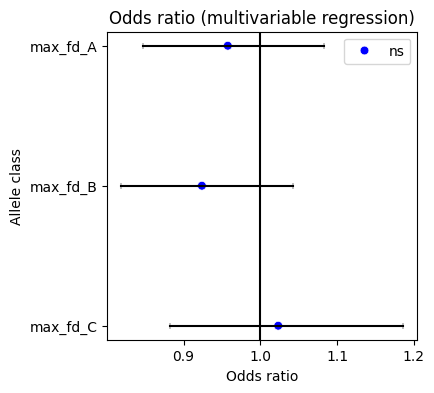

In [ ]:

# now we can plot that 
plt.figure(figsize = (4,4))

# add confidence intervals
sns.scatterplot(x = df_multi_odds['lower'], y = 'allele', color = 'black', marker='|', data = df_multi_odds, s = 20)
sns.scatterplot(x = df_multi_odds['upper'], y = 'allele', color = 'black', marker='|', data = df_multi_odds, s = 20)

for i in range(len(df_multi_odds['allele'])):
    plt.plot([df_multi_odds['lower'][i], df_multi_odds['upper'][i]], [i, i], color='black')

# add odds (main datapoints)
df_multi_odds['stat_sig'] = df_multi_odds['p_value'] < 0.05 
df_multi_odds['stat_sig2'] = df_multi_odds['stat_sig'].map({True: 'p < 0.05', False: 'ns'})

colors = ['blue', 'red']

sns.scatterplot(x = 'odds', y = 'allele', hue = 'stat_sig2', data = df_multi_odds, s = 40, alpha = 1, palette = colors)

# add vertical line to plot
plt.axvline(x=1, color='black')  # Adjust the x value as needed

# add x and y axis labels
plt.title('Odds ratio (multivariable regression)')
plt.ylabel('Allele class')
plt.xlabel('Odds ratio')
plt.legend()

plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_multivar_regression_FD.pdf', bbox_inches='tight')


In [ ]:
# we can also do uni regression on each feature separately

features = ['max_fd_A', 'max_fd_B', 'max_fd_C']

for feat in features:

    X = df_all_subset_clean[feat]
    y = df_all_subset_clean['ch_status']

    import statsmodels.api as sm

    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit()
    intercept_multi = result.params[0]
    coefficients_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues
    print('Intercept =', intercept_multi)
    print('Coefficients =', coefficients_multi)


# Regression on divergence by NetMHC score correlation

In [ ]:

# we first need to get the scores in the correct format

def get_corr_df_long(df):
    
    data = [] # store the data 

    # Iterate through each row and column of the correlation DataFrame
    for i in range(len(df.index)):
        for j in range(i + 1, len(df.columns)):  # Loop only through the upper triangle of the correlation matrix
            a1 = df.index[i]  # Object 1
            a2 = df.columns[j]  # Object 2
            correlation_coefficient = df.iloc[i, j]  # Correlation coefficient
            data.append((a1, a2, correlation_coefficient))

    # Create a new DataFrame from the list of tuples
    long_df = pd.DataFrame(data, columns=['Allele 1', 'Allele 2', 'Correlation Coefficient'])
    return long_df


In [ ]:

# change dataframe format 
netmhc_a_pairwise_corr_long = get_corr_df_long(netmhc_a_pairwise_corr_sub)
netmhc_b_pairwise_corr_long = get_corr_df_long(netmhc_b_pairwise_corr_sub)
netmhc_c_pairwise_corr_long = get_corr_df_long(netmhc_c_pairwise_corr_sub)

# add column to indicate allele combination
netmhc_a_pairwise_corr_long['allele_comb'] = netmhc_a_pairwise_corr_long['Allele 1'] + '-' + netmhc_a_pairwise_corr_long['Allele 2']
netmhc_b_pairwise_corr_long['allele_comb'] = netmhc_b_pairwise_corr_long['Allele 1'] + '-' + netmhc_b_pairwise_corr_long['Allele 2']
netmhc_c_pairwise_corr_long['allele_comb'] = netmhc_c_pairwise_corr_long['Allele 1'] + '-' + netmhc_c_pairwise_corr_long['Allele 2']

In [ ]:

# we want as different as possible so find something that has lowest correlation coefficient

def find_min_correlation(row, df):

    # initialize an empty dictionary
    scores = {}

    # determine which allele class we have
    allele_class = df['allele_comb'].str[0][0]
    
    # identify combinations present 
    # first column is Person ID and last column is ch_status
    cols_comb = row.index[1:-1][row[1:-1] >= 1]
        
    # select the highest divergence from the FD dataset 
    corr_present = df[df['allele_comb'].isin(cols_comb)]['Correlation Coefficient'].tolist()
    
    if len(corr_present) == 0: # possible that someone did not have combinations they screened 
        corr_min = None 
    else:
        corr_min = min(corr_present)
    
    # add fd_max to the dictionary 
    scores[f'min_corr_{allele_class}'] = corr_min
    
    # we want to return a series 
    return pd.Series(scores)


In [ ]:

# add minimum correlation / most different 
df_a_corr = pd.concat([df_hla1_a_comb, df_hla1_a_comb.apply(find_min_correlation, df=netmhc_a_pairwise_corr_long, axis=1)], axis=1)
df_b_corr = pd.concat([df_hla1_b_comb, df_hla1_b_comb.apply(find_min_correlation, df=netmhc_b_pairwise_corr_long, axis=1)], axis=1)
df_c_corr = pd.concat([df_hla1_c_comb, df_hla1_c_comb.apply(find_min_correlation, df=netmhc_c_pairwise_corr_long, axis=1)], axis=1)


In [ ]:

# okay now for each df, subset relevant columns and then merge
df_a_corr_subset = df_a_corr[['Person_ID', 'min_corr_A', 'ch_status']]
df_b_corr_subset = df_b_corr[['Person_ID', 'min_corr_B', 'ch_status']]
df_c_corr_subset = df_c_corr[['Person_ID', 'min_corr_C', 'ch_status']]

df_all_corr = pd.merge(df_a_corr_subset, df_b_corr_subset, on = ['Person_ID', 'ch_status'])
df_all_corr = pd.merge(df_all_corr, df_c_corr_subset, on = ['Person_ID', 'ch_status'])

In [ ]:

# multivariable regression model (all possible useful data I can think about)
features = ['min_corr_A', 'min_corr_B', 'min_corr_C']

# we have 99.5k people and max 1k lack predictions so tbf I'd just call it a day and remove the NaNs
df_all_corr_clean = df_all_corr.dropna()

X = df_all_corr_clean[features]
y = df_all_corr_clean['ch_status']

import statsmodels.api as sm

model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
result = model.fit()
intercept_multi = result.params[0]
coefficients_multi = result.params
confint_multi = result.conf_int()
pvalues_multi = result.pvalues
print('Intercept =', intercept_multi)
print('Coefficients =', coefficients_multi)

Optimization terminated successfully.
         Current function value: 0.103247
         Iterations 8
Intercept = -4.168029229220105
Coefficients = const        -4.168029
min_corr_A    0.023270
min_corr_B    0.328884
min_corr_C    0.128170
dtype: float64


In [ ]:

# okay so we have that done so let's plot this 
# this is for MULTI variable regression

log_odds_features_multi = coefficients_multi[1:] # this is the total log odds (baseline + difference)
odds_features_multi = [np.exp(lo) for lo in log_odds_features_multi] # we want to move from log odds to odds 

odds_baseline_multi = np.exp(intercept_multi) # this is the baseline odds ratio (1)
all_odds_ratios = [odds / odds_baseline_multi for odds in odds_features_multi] # change each to odds ratio (odds / baseline)

labels = ['min_corr_A', 'min_corr_B', 'min_corr_C']
df_multi_odds = pd.DataFrame({'allele' : labels})
df_multi_odds['odds'] = odds_features_multi
df_multi_odds['odds_ratio'] = all_odds_ratios

# add confidence intervals
confint_multi_df = pd.DataFrame(confint_multi)
confint_multi_df = confint_multi_df.reset_index()
confint_multi_df = confint_multi_df.rename(columns={'index': 'allele' , 0: 'lower', 1: 'upper'})
confint_multi_df['lower'] = np.exp(confint_multi_df['lower'])
confint_multi_df['upper'] = np.exp(confint_multi_df['upper'])
df_multi_odds = pd.merge(df_multi_odds, confint_multi_df.iloc[1:], on = 'allele')

# add p values
pval_list = pvalues_multi[1:].tolist()
df_multi_odds['p_value'] = pval_list # the first is for the baseline so we don't need that 


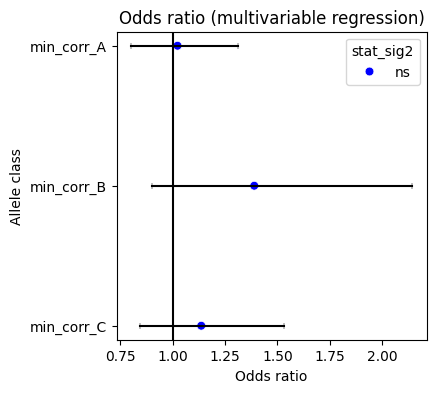

In [ ]:
# now we can plot that 
plt.figure(figsize = (4,4))

# add confidence intervals
sns.scatterplot(x = df_multi_odds['lower'], y = 'allele', color = 'black', marker='|', data = df_multi_odds, s = 20)
sns.scatterplot(x = df_multi_odds['upper'], y = 'allele', color = 'black', marker='|', data = df_multi_odds, s = 20)

for i in range(len(df_multi_odds['allele'])):
    plt.plot([df_multi_odds['lower'][i], df_multi_odds['upper'][i]], [i, i], color='black')

# add odds (main datapoints)
df_multi_odds['stat_sig'] = df_multi_odds['p_value'] < 0.05 
df_multi_odds['stat_sig2'] = df_multi_odds['stat_sig'].map({True: 'p < 0.05', False: 'ns'})

colors = ['blue', 'red']

sns.scatterplot(x = 'odds', y = 'allele', hue = 'stat_sig2', data = df_multi_odds, s = 40, alpha = 1, palette = colors)

# add vertical line to plot
plt.axvline(x=1, color='black')  # Adjust the x value as needed

# add x and y axis labels
plt.title('Odds ratio (multivariable regression)')
plt.ylabel('Allele class')
plt.xlabel('Odds ratio')
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_multivar_regression_corr.pdf', bbox_inches='tight')


# More considerations

# Looking at lung cancer results (cf Krishna 2024 Science)

Total number of lung cancer cases: 3707
Number of lung cancer cases in non-smokers: 327
Number of lung cancer cases in ever smokers: 3380


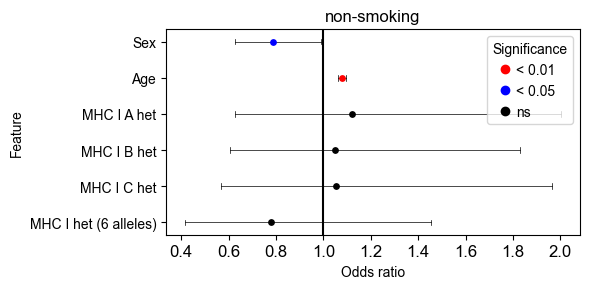

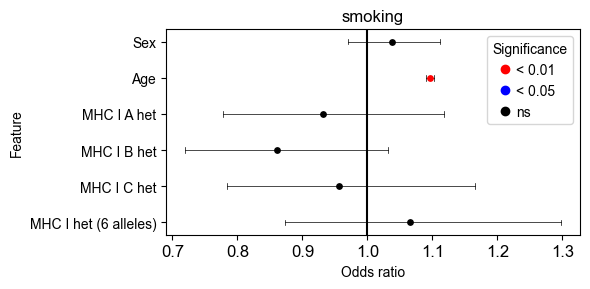

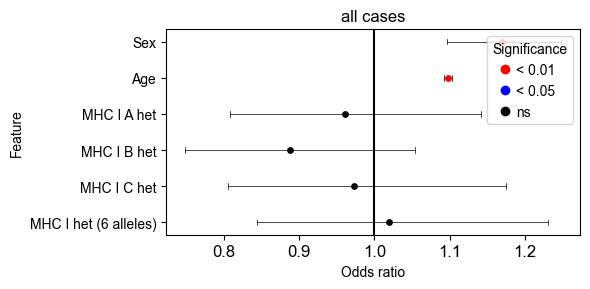

In [107]:

# would be good to see if we can reproduce what Krishna et al observed for lung cancers
# now we will run a model only with MHC-associated parameters (no sex age etc)

# okay first check the numbers
# in Krishna et al, they report 2468 cancer cases
# 1107 current smokers, 1035 former smokers and 326 non-smokers 

print('Total number of lung cancer cases:', combined_df_clean.C34.value_counts().values[1])
print('Number of lung cancer cases in non-smokers:',combined_df_clean[combined_df_clean['Ever smoker']==0].C34.value_counts().values[1])
print('Number of lung cancer cases in ever smokers:',combined_df_clean[combined_df_clean['Ever smoker']==1].C34.value_counts().values[1])

# with more features (ie age, sex, smoking)
# prepare features and outcome column 

dict_intercepts_sm = {}
dict_coefficients_sm = {}
dict_confints_sm = {}
dict_pvalues_sm = {}

smoking_status = [float(0), float(1)]
outcome = 'C34'
features = ['Sex', 'Age', 'MHC I A het', 'MHC I B het', 'MHC I C het', 'MHC I het (6 alleles)'] 

for smoking in smoking_status:

    combined_df_clean_smoking = combined_df_clean[combined_df_clean['Ever smoker']==smoking]

    # note: features only MHC-associated 
    X = combined_df_clean_smoking[features]
    y = combined_df_clean_smoking[outcome].astype('bool')
    model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
    result = model.fit(disp = 0)
    intercept_multi = result.params[0]
    coeff_multi = result.params
    confint_multi = result.conf_int()
    pvalues_multi = result.pvalues

    # save to a dictionary for plotting 
    dict_intercepts_sm[smoking] = intercept_multi
    dict_coefficients_sm[smoking] = coeff_multi
    dict_confints_sm[smoking] = confint_multi
    dict_pvalues_sm[smoking] = pvalues_multi

# now take any 
smoking = 'any'
X = combined_df_clean[features]
y = combined_df_clean[outcome].astype('bool')
model = sm.Logit(y, sm.add_constant(X)) # the add_constant is here so the model also includes the intercept 
result = model.fit(disp = 0)
intercept_multi = result.params[0]
coeff_multi = result.params
confint_multi = result.conf_int()
pvalues_multi = result.pvalues

# save to a dictionary for plotting 
dict_intercepts_sm[smoking] = intercept_multi
dict_coefficients_sm[smoking] = coeff_multi
dict_confints_sm[smoking] = confint_multi
dict_pvalues_sm[smoking] = pvalues_multi
    
# plot results for smokers vs non-smokers

# plot

for smoking, coef_dict in dict_coefficients_sm.items():

    # first, determine what outcome we are looking at 
    if smoking == float(1):
        descriptor = 'smoking'
    elif smoking == float(0):
        descriptor = 'non-smoking'
    elif smoking == 'any':
        descriptor = 'all cases'
    else:
        print('error')

    # initialize figure (separate for each outcome)
    plt.figure(figsize=(6, 3))
    plt.title(descriptor)

    # Calculate odds ratio for the intercept term
    intercept = dict_coefficients_sm[smoking][0]
    intercept_odds_ratio = np.exp(intercept) / np.exp(intercept)

    coeff_odds_ratios = []
    
    # find coefficient values 
    coefficients = dict_coefficients_sm[smoking][1:] # the first term is intercept so need to skip that 

    # find confidence intervals for the outcome
    confint = dict_confints_sm[smoking]
    confint = confint.reset_index()

    # specify where to take p values from
    pvalues = dict_pvalues_sm[smoking][1:] # first p value is for the intercept 

    # Get confidence interval for the feature

    for i, feature in enumerate(features):

        # calculate odds ratio when the feature is included 
        coeff_odds_ratio = calculate_odds_ratio(coefficients[i])
        coeff_odds_ratios.append(coeff_odds_ratio)

        lower_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][0])) 
        upper_ci = calculate_odds_ratio(float(confint[confint['index'] == feature][1]))
        
        if pvalues[i] < 0.01:
            color = 'red'
        elif pvalues[i] < 0.05:
            color = 'blue'
        else:
            color = 'black'
    
        plt.scatter(coeff_odds_ratios[i], features[i], alpha = 1, s = 15, color = color, zorder = 2, marker='o')
        plt.plot([lower_ci, upper_ci], [features[i], features[i]], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([lower_ci, lower_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)
        plt.plot([upper_ci, upper_ci], [i-0.08, i+0.08], color = 'black', zorder = 1, linewidth = 0.5)

    plt.axvline(x = intercept_odds_ratio, color = 'black')    
    plt.xlabel('Odds ratio')
    plt.ylabel('Feature')
    # plt.xlim(0.5, 1.5) # not having this here because effects of sex / smoking can be really large 
    plt.xticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.gca().invert_yaxis()

    # add legend
    legend_handles = []
    pvalues_list = [0.0001, 0.04, 1]
    significance_levels = ['< 0.01', '< 0.05', 'ns']
    for p_val, significance_level in zip(pvalues_list, significance_levels):
        # Determine color based on p-value
        if p_val < 0.01:
            color = 'red'
        elif p_val < 0.05:
            color = 'blue'
        else:
            color = 'black'
        
        # Create a proxy artist with the appropriate color
        legend_handles.append(plt.Line2D([0], [0], marker = 'o', color=color, label=significance_level))

    plt.legend(handles=legend_handles, loc='upper right', title='Significance', handlelength = 0)

    # Plot the odds ratio along with its confidence interval
    # note: first array is for x coordinates, second array is for y cordinates
    plt.tight_layout()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure10/{timestr}/{timestr}_lung_cancer_compare_regression_{smoking}.pdf', bbox_inches='tight')


- okay I am not getting exactly what they got and my confidence intervals are a bit wider
- however, the overall trend is very similar and it feels like the numbers are close enough
- I am really confused given I have more data than they have I should not have larger CIs 
- but it could be that somehow stuff is more variable / I have fewer features